<a href="https://colab.research.google.com/github/armandossrecife/teste/blob/main/Analysis_of_the_behavior_of_files_with_ATD_of_calculated_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

## Import dependencies

In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats

In [ ]:
pd.set_option('display.max_colwidth', None)

## Import dataset

Note: This dataset comes from the analyzes performed previously in the Cassandra repository. Tests are available at [Analysis of Cassandra](https://colab.research.google.com/drive/1vV2Yg41eZKj7Ws--B9lAHTeyh___m2mj?usp=sharing)

In [ ]:
!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/my_composition.csv

--2022-06-23 15:49:01--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/my_composition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86608 (85K) [text/plain]
Saving to: ‘my_composition.csv’

my_composition.csv  100%[===================>]  84.58K  --.-KB/s    in 0.01s   

2022-06-23 15:49:01 (6.25 MB/s) - ‘my_composition.csv’ saved [86608/86608]



In [ ]:
!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/files_nloc_complexity.csv

--2022-06-23 15:49:01--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/files_nloc_complexity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1242641 (1.2M) [text/plain]
Saving to: ‘files_nloc_complexity.csv’

files_nloc_complexi 100%[===================>]   1.18M  --.-KB/s    in 0.05s   

2022-06-23 15:49:02 (22.4 MB/s) - ‘files_nloc_complexity.csv’ saved [1242641/1242641]



In [ ]:
!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/critical_files_nloc_complexity_start_end.csv

--2022-06-23 15:49:02--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/critical_files_nloc_complexity_start_end.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635 [text/plain]
Saving to: ‘critical_files_nloc_complexity_start_end.csv’

critical_files_nloc 100%[===================>]     635  --.-KB/s    in 0s      

2022-06-23 15:49:02 (21.2 MB/s) - ‘critical_files_nloc_complexity_start_end.csv’ saved [635/635]



## Cloning repository

In [ ]:
!git clone https://github.com/apache/cassandra.git

Cloning into 'cassandra'...
remote: Enumerating objects: 367778, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 367778 (delta 14), reused 54 (delta 6), pack-reused 367708
Receiving objects: 100% (367778/367778), 369.92 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (213677/213677), done.


In [ ]:
!cd cassandra && find . | wc -l

5645


## Load data from commits and files

In [ ]:
# Carrega o banco de dados das análises de commis entre as versoes v.3.0.0 e v.3.11.11 do Cassandra 
# Baixa o arquivo sqlite do banco dos commmits do Cassandra
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n2RE3xsLtD-fv_omcI6vtm6x5si-PxmZ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1n2RE3xsLtD-fv_omcI6vtm6x5si-PxmZ" -O msrcassandra300to31111.db && rm -rf /tmp/cookies.txt

--2022-06-23 15:49:56--  https://docs.google.com/uc?export=download&confirm=t&id=1n2RE3xsLtD-fv_omcI6vtm6x5si-PxmZ
Resolving docs.google.com (docs.google.com)... 108.177.13.102, 108.177.13.138, 108.177.13.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jaft23vfpe5fk3bqkqgqce8qcp93l5ls/1655999325000/13935452558485945860/*/1n2RE3xsLtD-fv_omcI6vtm6x5si-PxmZ?e=download [following]
--2022-06-23 15:49:56--  https://doc-0g-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jaft23vfpe5fk3bqkqgqce8qcp93l5ls/1655999325000/13935452558485945860/*/1n2RE3xsLtD-fv_omcI6vtm6x5si-PxmZ?e=download
Resolving doc-0g-04-docs.googleusercontent.com (doc-0g-04-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-0g-04-docs.googleusercontent.com (doc-0g-04

In [ ]:
# Carrega as tabelas do banco em dataframes

import pandas as pd
import sqlite3

DATA_BASE='msrcassandra300to31111.db'
con = sqlite3.connect(DATA_BASE)

my_query_commits = "select * from commitscomplete"
my_query_files = "select * from filescomplete"
my_query_files_commits = "select f.id as 'file_id', f.hash as 'file_hash_commit', f.description as 'file_description', f.is_java as 'file_is_java', f.created_date as 'file_created_date', f.old_path as 'file_old_path', f.new_path as 'file_new_path', f.filename as 'file_filename', f.change_type as 'file_change_type', f.diff as 'file_diff', f.diff_parsed as 'file_diff_parsed', f.added_lines as 'file_added_lines', f.deleted_lines as 'file_deleted_lines', f.source_code as 'file_source_code', f.source_code_before as 'file_source_code_before', f.nloc as 'file_nloc', f.complexity as 'file_complexity', f.token_count as 'file_token_count', f.commit_id as 'file_commit_id', c.* from filescomplete f, commitscomplete c where f.commit_id=c.id"

df_commits_from_db = pd.read_sql_query(my_query_commits, con)
df_files_from_db = pd.read_sql_query(my_query_files, con)
df_files_commits_from_db = pd.read_sql(my_query_files_commits, con)

con.close()

In [ ]:
# Faz alguns ajustes nos dataframes
df_files_from_db['modified_lines'] = df_files_from_db.added_lines + df_files_from_db.deleted_lines
df_files_commits_from_db['modified_lines'] = df_files_commits_from_db.file_added_lines + df_files_commits_from_db.file_deleted_lines

In [ ]:
df_files_commits_from_db.columns

Index(['file_id', 'file_hash_commit', 'file_description', 'file_is_java',
       'file_created_date', 'file_old_path', 'file_new_path', 'file_filename',
       'file_change_type', 'file_diff', 'file_diff_parsed', 'file_added_lines',
       'file_deleted_lines', 'file_source_code', 'file_source_code_before',
       'file_nloc', 'file_complexity', 'file_token_count', 'file_commit_id',
       'id', 'name', 'hash', 'msg', 'author', 'committer', 'author_date',
       'author_timezone', 'committer_date', 'committer_timezone', 'branches',
       'in_main_branch', 'merge', 'modified_files', 'parents', 'project_name',
       'project_path', 'deletions', 'insertions', 'lines', 'files',
       'dmm_unit_size', 'dmm_unit_complexity', 'dmm_unit_interfacing',
       'modified_lines'],
      dtype='object')

In [ ]:
developers_cassandra = df_files_commits_from_db[['author']]
lista_developers_cassandra = []
nome_developer = []
email_developer = []
for each in developers_cassandra.author:
  each = each.split(',')
  nome_developer.append(each[0])
  email_developer.append(each[1])
  elemento = each[0]
  lista_developers_cassandra.append(elemento)
print(nome_developer)
print(email_developer)

['Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Jason Brown', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Jason Brown', 'Jason Brown', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Ariel Weisberg', 'Benedict Elliott Smith', 'Paulo Motta', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Benedict Elliott Smith', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Robert Stupp', 'Tommy Stendahl', 'Sylvain Lebresne', 'S

In [ ]:
from collections import Counter

In [ ]:
import operator
x = Counter(email_developer)
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
sorted_x_dec = reversed(sorted_x)
lista_developers_mais_comitaram = list(sorted_x_dec)
lista_30_developers_mais_comitaram = []
i = 1
for each in lista_developers_mais_comitaram:
  if i <= 30: 
    lista_30_developers_mais_comitaram.append(each)
    i += 1
print(lista_30_developers_mais_comitaram)

[('snazy@snazy.de', 770), ('stefania.alborghetti@datastax.com', 735), ('oleksandr.petrov@gmail.com', 678), ('sylvain@datastax.com', 671), ('dbrosius@mebigfatguy.com', 600), ('b.lerer@gmail.com', 570), ('marcuse@apache.org', 515), ('pauloricardomg@gmail.com', 491), ('mck@apache.org', 476), ('branimir.lambov@datastax.com', 432), ('sam@beobal.com', 381), ('xedin@apache.org', 304), ('jake@apache.org', 224), ('benedict@apache.org', 224), ('bdeggleston@gmail.com', 206), ('tylerlhobbs@gmail.com', 202), ('yukim@apache.org', 202), ('jacek.lewandowski@datastax.com', 160), ('zhaoyangsingapore@gmail.com', 160), ('jmckenzie@apache.org', 160), ('jasedbrown@gmail.com', 157), ('carl@apache.org', 144), ('ariel.weisberg@datastax.com', 131), ('a.penya.garcia@gmail.com', 128), ('geoffrey_yu@apple.com', 117), ('s.podkowinski@gmail.com', 111), ('aleksey@apache.org', 111), ('michael@pbandjelly.org', 108), ('dikang85@gmail.com', 102), ('mshuler@apache.org', 86)]


In [ ]:
unique_nome_developer = list(set(nome_developer))


## Architectural Smell (Arcan2)

List classes with architectural smells

- Cyclical dependence
- hub like dependency

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kfSUPUnjKY-f9R1xLv81qqAkW7u7Fbuz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kfSUPUnjKY-f9R1xLv81qqAkW7u7Fbuz" -O smell-affects.csv && rm -rf /tmp/cookies.txt

--2022-06-23 15:50:12--  https://docs.google.com/uc?export=download&confirm=&id=1kfSUPUnjKY-f9R1xLv81qqAkW7u7Fbuz
Resolving docs.google.com (docs.google.com)... 108.177.13.101, 108.177.13.100, 108.177.13.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3b1ja2653iqtogtpbkqiqjd11453dk85/1655999400000/13935452558485945860/*/1kfSUPUnjKY-f9R1xLv81qqAkW7u7Fbuz?e=download [following]
--2022-06-23 15:50:14--  https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3b1ja2653iqtogtpbkqiqjd11453dk85/1655999400000/13935452558485945860/*/1kfSUPUnjKY-f9R1xLv81qqAkW7u7Fbuz?e=download
Resolving doc-08-04-docs.googleusercontent.com (doc-08-04-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-08-04-docs.googleusercontent.com (doc-08-04-

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Tp0lgajYUQQiLKzzICST_o96m3it3yDr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Tp0lgajYUQQiLKzzICST_o96m3it3yDr" -O smell-characteristics.csv && rm -rf /tmp/cookies.txt

--2022-06-23 15:50:18--  https://docs.google.com/uc?export=download&confirm=&id=1Tp0lgajYUQQiLKzzICST_o96m3it3yDr
Resolving docs.google.com (docs.google.com)... 108.177.13.138, 108.177.13.100, 108.177.13.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nek08ufdcqkcis3chhkva6i17jb1r0fc/1655999400000/13935452558485945860/*/1Tp0lgajYUQQiLKzzICST_o96m3it3yDr?e=download [following]
--2022-06-23 15:50:22--  https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nek08ufdcqkcis3chhkva6i17jb1r0fc/1655999400000/13935452558485945860/*/1Tp0lgajYUQQiLKzzICST_o96m3it3yDr?e=download
Resolving doc-08-04-docs.googleusercontent.com (doc-08-04-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-08-04-docs.googleusercontent.com (doc-08-04-

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uN8uNp7Ek6CfYmVrAaYtaRxCGyj4DEwv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uN8uNp7Ek6CfYmVrAaYtaRxCGyj4DEwv" -O component-metrics.csv && rm -rf /tmp/cookies.txt

--2022-06-23 15:50:23--  https://docs.google.com/uc?export=download&confirm=&id=1uN8uNp7Ek6CfYmVrAaYtaRxCGyj4DEwv
Resolving docs.google.com (docs.google.com)... 108.177.13.101, 108.177.13.102, 108.177.13.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jo85ugtsu0qct3gnopoflt9kpcqb6108/1655999400000/13935452558485945860/*/1uN8uNp7Ek6CfYmVrAaYtaRxCGyj4DEwv?e=download [following]
--2022-06-23 15:50:23--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jo85ugtsu0qct3gnopoflt9kpcqb6108/1655999400000/13935452558485945860/*/1uN8uNp7Ek6CfYmVrAaYtaRxCGyj4DEwv?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Xv46b6xXDv0Bmc8J5MF_3c-WhViDvexn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Xv46b6xXDv0Bmc8J5MF_3c-WhViDvexn" -O component-membership.csv && rm -rf /tmp/cookies.txt

--2022-06-23 15:50:24--  https://docs.google.com/uc?export=download&confirm=&id=1Xv46b6xXDv0Bmc8J5MF_3c-WhViDvexn
Resolving docs.google.com (docs.google.com)... 108.177.13.101, 108.177.13.139, 108.177.13.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e78cfkc72v3ig1ldl8s4b83pm8mvb34l/1655999400000/13935452558485945860/*/1Xv46b6xXDv0Bmc8J5MF_3c-WhViDvexn?e=download [following]
--2022-06-23 15:50:25--  https://doc-0k-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e78cfkc72v3ig1ldl8s4b83pm8mvb34l/1655999400000/13935452558485945860/*/1Xv46b6xXDv0Bmc8J5MF_3c-WhViDvexn?e=download
Resolving doc-0k-04-docs.googleusercontent.com (doc-0k-04-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-0k-04-docs.googleusercontent.com (doc-0k-04-

In [ ]:
PATH_OUTPUT_TESTES_ARCAN2_CASSANDRA="/content"

df_smell_affected = pd.read_csv(PATH_OUTPUT_TESTES_ARCAN2_CASSANDRA + '/' + 'smell-affects.csv')
df_smell_characteristics = pd.read_csv(PATH_OUTPUT_TESTES_ARCAN2_CASSANDRA + '/' + 'smell-characteristics.csv')
df_component_metrics = pd.read_csv(PATH_OUTPUT_TESTES_ARCAN2_CASSANDRA + '/' + 'component-metrics.csv')
df_component_membership = pd.read_csv(PATH_OUTPUT_TESTES_ARCAN2_CASSANDRA + '/' + 'component-membership.csv') 

In [ ]:
df_smell_affected[['version', 'componentNameInVersion', 'edgeLabel', 'smellIdInVersion']]
df_smell_characteristics[['version', 'smellType', 'AffectedLevel','Shape', 'affectedElements']]
df_component_metrics[['version', 'name', 'componentLabel', 'componentType', 'LinesOfCode', 'TotalAmountOfChanges', 'filePathReal']]
df_component_membership[['version', 'childName', 'parentName']]

# DataFrame com as classes que possuem Cycle Dependency
df_cycle_dependency = df_smell_characteristics[ ['smellType','affectedElements'] ].query("smellType=='cyclicDep'")
# DataFrame com as classes que possuem Hublike Dependency
df_hublike_dependency = df_smell_characteristics[ ['smellType','affectedElements'] ].query("smellType=='hubLikeDep'")

## Creating the Dependency Matrix (DSM)

DSM: fa depends on fb

	   f1 f2 f3 ... fn

f1   x  1  0 ...  0

f2   0  x  1 ...  1

f3   0  0  x ...  0

f1 depends on f2, f2 depends on f3

DSM1 ( dicionario_dsm['fa'] ) -> dado o arquivo fa retorna todos os arquivos que fa usa

DSM2 ( dicionario_dsm_depende_de['fa'] ) -> dado o arquivo fa retorna todos os arquivos que dependem de fa

In [ ]:
# Gera um arquivo contendo todos os arquivos .java do projeto Cassandra
!find cassandra/src/java/org/apache/cassandra -name "*.java" > arquivosjava.txt

In [ ]:
# Cria duas listas contendo o conjunto de arquivos da versão analisada
lista_linhas_arquivos_cassandra = []
lista_colunas_arquivos_cassandra = []

with open('arquivosjava.txt', mode='r+', encoding='utf-8') as file:
  for line in file:  
    line = line.rstrip()
    line = line.replace('cassandra/src/java/', '')
    line = line.replace('/', '.')
    lista_linhas_arquivos_cassandra.append(line)
    lista_colunas_arquivos_cassandra.append(line)

In [ ]:
# Dado 'org.apache.cassandra.index.Index.java'
# Retorne 'pilot/analises/designite/v-3-11-11/src/java/org/apache/cassandra/index/Index.java'

def get_path_file(my_file, src_java_path='cassandra/src/java/'):
  path_file = None
  my_file = my_file.replace('.java', '') # org.apache.cassandra.index.Index
  my_file = my_file.replace('.', '/') # org/apache/cassandra/index/Index
  my_file = my_file + '.java' # org/apache/cassandra/index/Index.java
  path_file =  src_java_path  + my_file 
  return path_file

def teste_find_word_in_file(my_file, my_word):
    with open(my_file) as f:
        datafile = f.readlines()
        found = False  # This isn't really necessary
        for line in datafile:
          if my_word in line:
            # found = True # Not necessary
            return True
    return False  # Because you finished the search without finding
  
def lista_arquivos_que_dependem_de(my_file, dicionario):
  lista_temp = []
  my_file = my_file.replace('/','.')
  if my_file in dicionario:
    for each in dicionario[my_file]:
      if each[2] == 1: 
        lista_temp.append(each)
  return lista_temp

DSM File A usa File B

In [ ]:
import datetime

t1 = datetime.datetime.now()

dicionario_dsm = {}
lista_aux = []

for each_file in lista_linhas_arquivos_cassandra:
  for each_elemento_coluna in lista_colunas_arquivos_cassandra:
    my_search = each_elemento_coluna
    my_search = my_search.replace('.java', ';')
    my_path = get_path_file(my_file=each_file)
    if teste_find_word_in_file(my_file=my_path,my_word=my_search):
      item = (each_file, each_elemento_coluna, 1)
    else:
      item = (each_file, each_elemento_coluna, 0)
    lista_aux.append(item)
  dicionario_dsm[each_file] = lista_aux 
  lista_aux = []
  
t2 = datetime.datetime.now()

delta = t2 - t1

print(f'Tempo para criar o dicionarário dsm: {delta}, itens percorridos: {len(dicionario_dsm)}')

Tempo para criar o dicionarário dsm: 0:04:18.157110, itens percorridos: 2126


DSM File A depende de File B

In [ ]:
t1 = datetime.datetime.now()

dicionario_dsm_depende_de = {}
lista_aux = []

for each_file in lista_linhas_arquivos_cassandra:
  for each_elemento_coluna in lista_colunas_arquivos_cassandra:
    my_search = each_file
    my_search = my_search.replace('.java', ';')
    my_path = get_path_file(my_file=each_elemento_coluna)
    if teste_find_word_in_file(my_file=my_path,my_word=my_search):
      item = (each_elemento_coluna, each_file, 1)
    else:
      item = (each_elemento_coluna, each_file, 0)
    lista_aux.append(item)
  dicionario_dsm_depende_de[each_file] = lista_aux 
  lista_aux = []
  
t2 = datetime.datetime.now()

delta = t2 - t1

print(f'Tempo para criar o dicionarário dsm: {delta}, itens percorridos: {len(dicionario_dsm_depende_de)}')

Tempo para criar o dicionarário dsm: 0:04:48.789095, itens percorridos: 2126


In [ ]:
# Dada uma classe e o arquivo texto contendo todos os arquivos do repositorio, 
# retorna o pacote da classe junto com classe
def get_file_package(my_file, my_content):
  with open(my_content, mode='r+', encoding='utf-8') as file:
    for line in file:
      if my_file in line:
        line = line.replace('cassandra/src/java/', '')
        line = line.replace('/','.')
        line = line.strip()
        return line

# Dada a lista de arquivos criticos [(arquivo1, qtd linhas modificadas, frequencia de commits), (), ...]
# arquivo texto contendo todos os arquivos do repositorio
# dicionario com a DSM file_a uses file_b
# retorna o dicionario com chave file_a e valores lista de arquivos que file_a chama(importa)
def get_dict_file_a_uses_file_b(lista_arquivos_criticos, content='arquivosjava.txt', my_dictionary=dicionario_dsm):
  dict_file_a_uses_file_b = {}
  lista_file_a_uses_file_b = []
  for each in lista_arquivos_criticos:
    item = each[0]
    key_file = get_file_package(my_file=item, my_content=content)
    for each_tupla in my_dictionary[key_file]:
      if each_tupla[2] == 1:
        lista_file_a_uses_file_b.append(each_tupla[1])
    dict_file_a_uses_file_b[key_file] = lista_file_a_uses_file_b
    lista_file_a_uses_file_b = []
  return dict_file_a_uses_file_b

# Todo: revisar, pois está substituindo config.java por GuardrailsConfig.java
# Dada a lista de arquivos criticos [(arquivo1, qtd linhas modificadas, frequencia de commits), (), ...]
# arquivo texto contendo todos os arquivos do repositorio
# dicionario com a DSM file_a depende de file_b
# retorna o dicionario com chave file_a e valores lista de arquivos que dependem de file_a
def get_dict_file_impact_other_files(lista_arquivos_criticos, content='arquivosjava.txt', my_dictionary=dicionario_dsm_depende_de):
  dict_file_impact_other_files = {}
  lista_file_a_depends_on_file_b = []
  
  for each in lista_arquivos_criticos:
    item = each[0]
    key_file = get_file_package(my_file=item, my_content=content)
    for tupla in lista_arquivos_que_dependem_de(my_file=key_file, dicionario=my_dictionary):
      if tupla[2] == 1:
        lista_file_a_depends_on_file_b.append(tupla[0])
    dict_file_impact_other_files[key_file] = lista_file_a_depends_on_file_b
    lista_file_a_depends_on_file_b = []
  return dict_file_impact_other_files

## Files that depend on critical files

In [ ]:
# selecao de classes criticas que pertencem ao Q1 (quadrante1) -> Modified LOC ALTA e Frequencia de Commits Alta
lista_arquivos_criticos = [("StorageService.java", 3537, 144), ("ColumnFamilyStore.java", 1966, 89), ("DatabaseDescriptor.java", 2092, 87), ("CompactionManager.java", 1279, 74), ("StorageProxy.java", 1667, 53), ("SSTableReader.java", 767, 53), ("Config.java", 553, 52), ("CassandraDaemon.java", 1001, 51), ("SelectStatement.java", 1174, 44), ("SinglePartitionReadCommand.java", 994, 38),("NodeProbe.java", 513, 37), ("MessagingService.java", 574, 36)]

In [ ]:
# Dado um arquivo chave, mostra a lista de arquivos que dependem do arquivo chave
dict_arquivos_dependentes_arquivos_criticos = get_dict_file_impact_other_files(lista_arquivos_criticos)
dict_arquivos_dependentes_arquivos_criticos

{'org.apache.cassandra.config.DatabaseDescriptor.java': ['org.apache.cassandra.schema.PartitionDenylist.java',
  'org.apache.cassandra.schema.SystemDistributedKeyspace.java',
  'org.apache.cassandra.schema.KeyspaceMetadata.java',
  'org.apache.cassandra.schema.ReplicationParams.java',
  'org.apache.cassandra.schema.MemtableParams.java',
  'org.apache.cassandra.schema.TableMetadata.java',
  'org.apache.cassandra.schema.DefaultSchemaUpdateHandler.java',
  'org.apache.cassandra.audit.AuditLogManager.java',
  'org.apache.cassandra.audit.BinAuditLogger.java',
  'org.apache.cassandra.security.SSLFactory.java',
  'org.apache.cassandra.security.ThreadAwareSecurityManager.java',
  'org.apache.cassandra.locator.Replicas.java',
  'org.apache.cassandra.locator.TokenMetadata.java',
  'org.apache.cassandra.locator.EndpointSnitchInfo.java',
  'org.apache.cassandra.locator.ReplicationFactor.java',
  'org.apache.cassandra.locator.Ec2MultiRegionSnitch.java',
  'org.apache.cassandra.locator.SimpleStrateg

## Support Functions

In [ ]:
def get_filename_nloc_complexity(df, name):
  """
  Para cada arquivo lista os dados nloc_inicial, cc_inicial, nloc_final, cc_final  
  @param: df dataframe de entrada
  @param: name nome do arquivo
  @return tupla(filename, nloc_inicial, cc_inicial, nloc_final, cc_final)
  """
  my_query = f"filename == '{name}'" 
  df_temp = df.query(my_query)
  min = 0
  max = df_temp.shape[0] - 1
  row_filename_min = df_temp.iloc[[min]]
  row_filename_max = df_temp.iloc[[max]]
  index_min = row_filename_min.index[0]
  index_max = row_filename_max.index[0]

  filename = row_filename_min['filename'][index_min]
  filename_nloc_min = row_filename_min['nloc'][index_min]
  filename_complexity_min = row_filename_min['complexity'][index_min]
  filename_nloc_max = row_filename_max['nloc'][index_max]
  filename_complexity_max = row_filename_max['complexity'][index_max]
  return filename, filename_nloc_min, filename_complexity_min, filename_nloc_max, filename_complexity_max

def get_dataframe_filename_nloc_complexity(lista, df):
  """
  Dataframe dos arquivos criticos com seus dados
  @param: lista lista dos arquivos criticos pre-selecionados
  @param: df dataframe de entrada
  @return dataframe dos arquivos criticos com os dados filename, nloc_inicial, cc_inicial, nloc_final, cc_final
  """
  dict_temp = {}
  filename = []
  nloc_min = []
  complexity_min = []
  nloc_max = []
  complexity_max = []
  for each in lista:
    items = get_filename_nloc_complexity(df=df, name=each)
    filename.append(items[0])
    nloc_min.append(items[1])
    complexity_min.append(items[2])
    nloc_max.append(items[3])
    complexity_max.append(items[4])
  dict_temp = {'filename':filename, 'nloc_start':nloc_min, 'nloc_end':nloc_max, 'complexity_start':complexity_min, 'complexity_end':complexity_max}
  df_temp = pd.DataFrame(dict_temp)
  return df_temp

def get_df_filename_ordey_complexity(df, name):
  """
  Dataframe de um arquivo critico com seus dados
  @param: df dataframe dos arquivos criticos
  @param: name nome do arquivo que sera selecionado
  @return dataframe do arquivo com os dados filename, nloc_inicial, cc_inicial, nloc_final, cc_final
  """
  my_query = f"filename=='{name}'"
  result = df.query(my_query)
  return result[['filename', 'commit', 'commit_date', 'nloc', 'complexity']]

def show_time_series(df):
  """
  Mostra o grafico da serie temporal de um arquivo critico
  @param df dataframe do arquivo que sera plotado
  """
  fig = px.line(df, x='commit_date', y="complexity")
  fig.show()

In [ ]:
def save_df_to_latex(df, filename):
  with open(filename, 'w') as tf:
    tf.write(df.to_latex())

def convert_lists_to_df(q1, q2, q3, q4, name):
  category = ['None', 'Small', 'Medium', 'Large', 'Extra Large']
  p = [0, 25, 50, 75, 100]
  quartiles = ['-', 'Q1', 'Q2', 'Q3', 'Q4']
  values = [1, q1, q2, q3, q4]
  
  dict_temp = {'category':category, 'p':p, 'quartile':quartiles, f'{name}':values}
  df_temp = pd.DataFrame(dict_temp)
  return df_temp

# 1. Critical Files

Classes with Architectural Smells (Cyclic Dependency and Hub-like Dependency)

Critical files come from Cassandra tests available at [Analysis of Cassandra](https://colab.research.google.com/drive/1vV2Yg41eZKj7Ws--B9lAHTeyh___m2mj?usp=sharing)

In [ ]:
lista_nomes_arquivos_criticos = ['StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java','Config.java', 'CassandraDaemon.java','SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java']

In [ ]:
print(f'--- Arquivos críticos: {len(lista_nomes_arquivos_criticos)} ---')
for each in lista_nomes_arquivos_criticos:
  print(each)

--- Arquivos críticos: 12 ---
StorageService.java
ColumnFamilyStore.java
DatabaseDescriptor.java
CompactionManager.java
StorageProxy.java
SSTableReader.java
Config.java
CassandraDaemon.java
SelectStatement.java
SinglePartitionReadCommand.java
NodeProbe.java
MessagingService.java


# 2. Dataframe Files with LOC and Cyclomatic Complexity

Commit range: v3.0.0 to 3.11.11


## 2.1 All Cassandra repository files

In [ ]:
df_file_nloc_complexity = pd.read_csv('files_nloc_complexity.csv')
df_file_nloc_complexity

,Unnamed: 0,filename,commit,commit_date,nloc,complexity
0,0,Config.java,47341eb6aaca318d0ffc0e9f906b98db50b9e9ff,2015-08-03 18:33:15.000000,234.0,4.0
1,1,DatabaseDescriptor.java,47341eb6aaca318d0ffc0e9f906b98db50b9e9ff,2015-08-03 18:33:15.000000,1445.0,374.0
2,2,TransparentDataEncryptionOptions.java,47341eb6aaca318d0ffc0e9f906b98db50b9e9ff,2015-08-03 18:33:15.000000,47.0,10.0
3,3,CipherFactory.java,47341eb6aaca318d0ffc0e9f906b98db50b9e9ff,2015-08-03 18:33:15.000000,127.0,16.0
4,4,EncryptionContext.java,47341eb6aaca318d0ffc0e9f906b98db50b9e9ff,2015-08-03 18:33:15.000000,80.0,16.0
...,...,...,...,...,...,...
12249,12249,CHANGES.txt,3e54ed76b29b752f2c17baa98901adf47e5897d1,2021-07-25 11:37:33.000000,NaN,NaN
12250,12250,build.xml,3e54ed76b29b752f2c17baa98901adf47e5897d1,2021-07-25 11:37:33.000000,NaN,NaN
12251,12251,idea-iml-file.xml,8857d0448914c2b8bb3e4e8f5f49b1d369f53893,2021-07-25 11:37:33.000000,NaN,NaN
12252,12252,idea-iml-file.xml,4950878639056261746e24b2a5de29d739668e2d,2021-07-25 11:37:33.000000,NaN,NaN


## 2.2 Only Critical Files

List critical file data ordered by commit over time

### 2.2.1 Dataframe LOC and Complexity of Critical Files

In [ ]:
df = df_file_nloc_complexity
df_file_nloc_complexity_critic = df[df['filename'].isin(lista_nomes_arquivos_criticos)]
df_file_nloc_complexity_critic = df_file_nloc_complexity_critic.sort_values(['filename', 'commit_date'], ascending=True)
df_file_nloc_complexity_critic[['filename', 'commit', 'commit_date', 'nloc', 'complexity']]

,filename,commit,commit_date,nloc,complexity
53,CassandraDaemon.java,bd46463fbb7d6b0998c837450ce61df13eda041d,2015-09-30 15:43:43.000000,522.0,95.0
700,CassandraDaemon.java,879c49bb7d28946187a04e5cd76236d652825579,2015-12-04 14:22:36.000000,484.0,88.0
705,CassandraDaemon.java,a4da379bb042fcf171a560af5edd9e785d6f8e4e,2015-12-04 14:30:00.000000,518.0,95.0
761,CassandraDaemon.java,dff2214595c5e2b0b8f3781186df55bd90c6728c,2015-12-11 16:50:34.000000,471.0,82.0
2438,CassandraDaemon.java,11910c6c9206407c2de60f38566120bddde79eba,2016-03-10 14:43:01.000000,533.0,96.0
...,...,...,...,...,...
11636,StorageService.java,f6d19512c4d79f800371da1e54dfe01cae5d894e,2021-04-21 17:27:10.000000,4056.0,909.0
11648,StorageService.java,8fd046f2557e4d50e80986b813bc904dce625e6a,2021-04-23 15:08:22.000000,3734.0,836.0
11673,StorageService.java,d84c6e98106e7b0c205f019ee24d416d0bb65f37,2021-05-05 16:41:01.000000,3734.0,836.0
11834,StorageService.java,5f09226a0d56f6d2d5e60f83465f9f17beed0572,2021-05-28 15:57:38.000000,3736.0,836.0


In [ ]:
df_file_nloc_complexity_critic

,Unnamed: 0,filename,commit,commit_date,nloc,complexity
53,53,CassandraDaemon.java,bd46463fbb7d6b0998c837450ce61df13eda041d,2015-09-30 15:43:43.000000,522.0,95.0
700,700,CassandraDaemon.java,879c49bb7d28946187a04e5cd76236d652825579,2015-12-04 14:22:36.000000,484.0,88.0
705,705,CassandraDaemon.java,a4da379bb042fcf171a560af5edd9e785d6f8e4e,2015-12-04 14:30:00.000000,518.0,95.0
761,761,CassandraDaemon.java,dff2214595c5e2b0b8f3781186df55bd90c6728c,2015-12-11 16:50:34.000000,471.0,82.0
2438,2438,CassandraDaemon.java,11910c6c9206407c2de60f38566120bddde79eba,2016-03-10 14:43:01.000000,533.0,96.0
...,...,...,...,...,...,...
11636,11636,StorageService.java,f6d19512c4d79f800371da1e54dfe01cae5d894e,2021-04-21 17:27:10.000000,4056.0,909.0
11648,11648,StorageService.java,8fd046f2557e4d50e80986b813bc904dce625e6a,2021-04-23 15:08:22.000000,3734.0,836.0
11673,11673,StorageService.java,d84c6e98106e7b0c205f019ee24d416d0bb65f37,2021-05-05 16:41:01.000000,3734.0,836.0
11834,11834,StorageService.java,5f09226a0d56f6d2d5e60f83465f9f17beed0572,2021-05-28 15:57:38.000000,3736.0,836.0


### Critical files and behavior of LOCs and CCs

In [ ]:
df_filename_nloc_complexity = get_dataframe_filename_nloc_complexity(lista=lista_nomes_arquivos_criticos, df=df_file_nloc_complexity_critic)
df_filename_nloc_complexity

,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,StorageService.java,3306.0,3743.0,717.0,838.0
1,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0
2,DatabaseDescriptor.java,1445.0,1799.0,374.0,471.0
3,CompactionManager.java,1252.0,1654.0,194.0,265.0
4,StorageProxy.java,1867.0,2143.0,333.0,377.0
5,SSTableReader.java,1588.0,1600.0,322.0,324.0
6,Config.java,234.0,310.0,4.0,12.0
7,CassandraDaemon.java,522.0,643.0,95.0,117.0
8,SelectStatement.java,803.0,918.0,157.0,177.0
9,SinglePartitionReadCommand.java,350.0,884.0,63.0,157.0


In [ ]:
df_file_nloc_complexity_critic.query("filename=='StorageService.java'")

,Unnamed: 0,filename,commit,commit_date,nloc,complexity
222,222,StorageService.java,6bad57fc3cf967838a220d8402db37ed9a5b3b4e,2015-11-11 15:02:26.000000,3306.0,717.0
231,231,StorageService.java,6bb6bb005197c33fa94026d472ff78d4f36613cc,2015-11-11 15:04:25.000000,3302.0,703.0
240,240,StorageService.java,9a90e9894e9e079058876cf2b16a47d29ba0a32a,2015-11-11 15:05:35.000000,3344.0,718.0
257,257,StorageService.java,ecd66de2bdf2ecb88c4276a4616a76f5ec2921bb,2015-11-12 17:53:33.000000,3311.0,718.0
297,297,StorageService.java,a8e8a67306c0b26b8fe9c74a1fb00bacfa224cf7,2015-11-17 09:57:15.000000,3314.0,719.0
...,...,...,...,...,...,...
11636,11636,StorageService.java,f6d19512c4d79f800371da1e54dfe01cae5d894e,2021-04-21 17:27:10.000000,4056.0,909.0
11648,11648,StorageService.java,8fd046f2557e4d50e80986b813bc904dce625e6a,2021-04-23 15:08:22.000000,3734.0,836.0
11673,11673,StorageService.java,d84c6e98106e7b0c205f019ee24d416d0bb65f37,2021-05-05 16:41:01.000000,3734.0,836.0
11834,11834,StorageService.java,5f09226a0d56f6d2d5e60f83465f9f17beed0572,2021-05-28 15:57:38.000000,3736.0,836.0


### 2.2.2 Complexity behavior graphs of critical files

In [ ]:
for each in lista_nomes_arquivos_criticos:
  df = get_df_filename_ordey_complexity(df=df_file_nloc_complexity_critic, name=each)
  show_time_series(df)

# 3. Checks correlation between variables over time

Time range:

* Commit range: v3.0.0 to 3.11.11
* from 2015 to 2021

Variables:

* Number of lines changed over time (LM)
* Number of occurrences of files in commits (FC)
* Cyclomatic complexity of the files (CC)

In [ ]:
# Todos os arquivos do repositório cassandra
df_cassandra_atd = pd.read_csv('my_composition.csv')

# Filtra apenas os arquivos .java
df_cassandra_atd_java = df_cassandra_atd[df_cassandra_atd['filename'].str.contains(".java", regex=False)]

# Filtra apenas os arquivos Test dos .java
df_cassandra_atd_java_test = df_cassandra_atd[df_cassandra_atd['filename'].str.contains("Test", regex=False)]

## 3.1 Dataframe containing only the implementation .java files

* We removed doc/text files
* We removed configuration files
* We removed test files
* Other non-implementation files excluded

### Variables

* FC - Frequency of Files in Commits
* ML - Modified lines over time
* CC - Cyclomatic Complexity

In [ ]:
df_cassandra_atd_java_impl = df_cassandra_atd_java[df_cassandra_atd_java['filename'].str.contains('Test') == False]
df_cassandra_atd_java_impl

,filename,fc,ml,cc
0,Config.java,52,553,12
1,DatabaseDescriptor.java,87,2092,471
2,TransparentDataEncryptionOptions.java,1,76,10
3,CipherFactory.java,3,180,16
4,EncryptionContext.java,2,184,30
...,...,...,...,...
2535,RepeatableRunner.java,1,109,7
2536,BloomFilterTracker.java,1,25,9
2538,WrappedSimpleClient.java,1,67,9
2544,SSTableLevelResetter.java,1,7,10


In [ ]:
# Example for StorageService.java file
df_cassandra_atd_java_impl.query("filename=='StorageService.java'")

,filename,fc,ml,cc
168,StorageService.java,144,3537,838


## 3.2 Calculation of Spearman's Correlation Coefficient



In [ ]:
df_cassandra_atd_java_impl.corr(method='spearman').round(4)

,fc,ml,cc
fc,1.0000,0.6042,0.5267
ml,0.6042,1.0000,0.4535
cc,0.5267,0.4535,1.0000


In [ ]:
array_frequence_commit = df_cassandra_atd_java_impl.fc.values
array_modified_lines = df_cassandra_atd_java_impl.ml.values
print("Frequencia de Commits x Linhas Modificadas ao longo do tempo")
print(stats.spearmanr(array_modified_lines, array_frequence_commit))
print("")
array_cyclomatic_complexity = df_cassandra_atd_java_impl.cc.values
print("Frequencia de Commits x Complexidade Ciclomática ao longo do tempo")
print(stats.spearmanr(array_cyclomatic_complexity, array_frequence_commit))
print("")

Frequencia de Commits x Linhas Modificadas ao longo do tempo
SpearmanrResult(correlation=0.6042425757216745, pvalue=6.975859312984621e-141)

Frequencia de Commits x Complexidade Ciclomática ao longo do tempo
SpearmanrResult(correlation=0.5267322003717458, pvalue=2.460173295214021e-101)



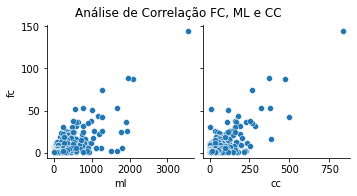

In [ ]:
ax = sns.pairplot(df_cassandra_atd_java_impl, y_vars='fc', x_vars=['ml', 'cc'])
ax.fig.suptitle('Análise de Correlação FC, ML e CC', fontsize=12, y=1.05)
ax

In [ ]:
id = []
name = []
my_type = []
data_collection = []
description = []

id.append('FC')
id.append('ML')
id.append('CC')
name.append('Frequence Commit')
name.append('Modified Lines')
name.append('Cyclomatic Complexity')
my_type.append('Independent')
my_type.append('Independent')
my_type.append('Independent')
data_collection.append('Repository Mining')
data_collection.append('Repository Mining')
data_collection.append('Repository Mining')
description.append('It is the amount of file occurrence in commits during the range analyzed.')
description.append('It is related to the accumulated modified lines over time for each selected file in the range analyzed.')
description.append('It is related to the Cyclomatic Complexity of each file selected in the range analyzed.')

dict_variables = {'id':id, 'name':name, 'my_type':my_type, 'data_colection':data_collection, 'description':description}
df_variables = pd.DataFrame(dict_variables)
dict_new_columns = {'id':'ID', 'name': 'Name', 'my_type':'Type', 'data_colection':'Data Collection', 'description': 'Description'}
df_variables = df_variables.rename(columns=dict_new_columns)

In [ ]:
df_variables

,ID,Name,Type,Data Collection,Description
0,FC,Frequence Commit,Independent,Repository Mining,It is the amount of file occurrence in commits during the range analyzed.
1,ML,Modified Lines,Independent,Repository Mining,It is related to the accumulated modified lines over time for each selected file in the range analyzed.
2,CC,Cyclomatic Complexity,Independent,Repository Mining,It is related to the Cyclomatic Complexity of each file selected in the range analyzed.


In [ ]:
save_df_to_latex(df_variables, 'variables.tex')

# Critical files maintainability index

In [ ]:
# https://www.fullstackpython.com/code-metrics.html
# https://pypi.org/project/multimetric/
# https://github.com/priv-kweihmann/multimetric
!pip install multimetric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for multimetric: filename=multimetric-1.3.0-py3-none-any.whl size=21199 sha256=c5c205f7c1f0a355f29c057e1ecc3e0b3498d6ef7e2f3316fa31fdad51e85697
  Stored in directory: /root/.cache/pip/wheels/0b/0f/85/e2cef4ccce11e09c0b90ed35c3d54fa5c50815dbffd8e8c548
Successfully built multimetric


In [ ]:
import json

# Dado o path do arquivo.java que sera analisado
# retorna o json com os resultados da analise
def generate_json_from_file_analysed(filepath):
  filename = filepath.split('/')[-1]
  !multimetric {filepath} > {filename}.json

# Dado um arquivo .json contendo a analise do arquivo.java
# retorna o maintainability_index
def get_maintainability_index(jsonfile='result.json'):
	with open(jsonfile) as json_file:
		data = json.load(json_file)

		for key, value in data.items():
		  if key == 'overall':
		    new_dict = value
		    for k, v in new_dict.items():
		      if k == 'maintainability_index':
		        return v

def get_full_path(filename):
  temp = !cd cassandra && find . -name {filename}.java
  return temp[0]

def get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_temp='/content/cassandra'):
  lista_nomes_arquivos_criticos_full_path = []
  for each in lista_nomes_arquivos_criticos:
    each = each.split('.')[-2]
    temp = get_full_path(each)
    temp = temp.split('.')
    temp = temp[-2] + '.' + temp[-1]
    temp = path_temp + temp
    lista_nomes_arquivos_criticos_full_path.append(temp)
  return lista_nomes_arquivos_criticos_full_path

def get_dict_filename_mi(lista_nomes_arquivos_criticos_full_path):
  dict_filename_mi = {}
  for each_file in lista_nomes_arquivos_criticos_full_path:
    jsonfile = generate_json_from_file_analysed(each_file)
    temp = each_file.split('.')
    filename = temp[-2].split('/')[-1] + "." + temp[-1]
    filename_json = filename + '.json'
    mi = get_maintainability_index(filename_json)
    dict_filename_mi[filename] = mi
  return dict_filename_mi

# Dado um arquivo .json contendo a analise do arquivo.java
# retorna o dict_index contendo: maintainability_index, halstead_bugprop, halstead_dificult, halstead_effort
def get_maintainability_and_halstead(jsonfile='result.json'):
  dict_index = {}
  with open(jsonfile) as json_file:
    data = json.load(json_file)
    for key, value in data.items():
      if key == 'overall':
        new_dict = value
        for k, v in new_dict.items():
          if k == 'maintainability_index':
            dict_index['maintainability_index'] = v
          if k == 'halstead_bugprop':
            dict_index['halstead_bugprop'] = v
          if k == 'halstead_difficulty':
            dict_index['halstead_difficulty'] = v
          if k == 'halstead_effort':
            dict_index['halstead_effort'] = v
  return dict_index


def get_dict_filename_mi_hst(lista_nomes_arquivos_criticos_full_path):
  dict_filename_mi_hst = {}
  for each_file in lista_nomes_arquivos_criticos_full_path:
    jsonfile = generate_json_from_file_analysed(each_file)
    temp = each_file.split('.')
    filename = temp[-2].split('/')[-1] + "." + temp[-1]
    filename_json = filename + '.json'
    mi_hst = get_maintainability_and_halstead(filename_json)
    dict_filename_mi_hst[filename] = mi_hst
  return dict_filename_mi_hst

In [ ]:
path_cassandra_300 = '/content/cassandra-cassandra-3.0.0'
path_cassandra_31111 = '/content/cassandra-cassandra-3.11.11'
path_cassandra_403 = '/content/cassandra'

In [ ]:
!wget https://github.com/apache/cassandra/archive/refs/tags/cassandra-3.0.0.zip

--2022-06-23 15:59:44--  https://github.com/apache/cassandra/archive/refs/tags/cassandra-3.0.0.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/apache/cassandra/zip/refs/tags/cassandra-3.0.0 [following]
--2022-06-23 15:59:45--  https://codeload.github.com/apache/cassandra/zip/refs/tags/cassandra-3.0.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cassandra-3.0.0.zip’

cassandra-3.0.0.zip     [              <=>   ]  27.28M  9.28MB/s    in 2.9s    

2022-06-23 15:59:48 (9.28 MB/s) - ‘cassandra-3.0.0.zip’ saved [28606083]



In [ ]:
!unzip cassandra-3.0.0.zip

Archive:  cassandra-3.0.0.zip
96f407bce56b98cd824d18e32ee012dbb99a0286
   creating: cassandra-cassandra-3.0.0/
  inflating: cassandra-cassandra-3.0.0/.gitignore  
  inflating: cassandra-cassandra-3.0.0/.rat-excludes  
  inflating: cassandra-cassandra-3.0.0/CHANGES.txt  
  inflating: cassandra-cassandra-3.0.0/CONTRIBUTING.md  
  inflating: cassandra-cassandra-3.0.0/LICENSE.txt  
  inflating: cassandra-cassandra-3.0.0/NEWS.txt  
  inflating: cassandra-cassandra-3.0.0/NOTICE.txt  
  inflating: cassandra-cassandra-3.0.0/README.asc  
   creating: cassandra-cassandra-3.0.0/bin/
  inflating: cassandra-cassandra-3.0.0/bin/cassandra  
  inflating: cassandra-cassandra-3.0.0/bin/cassandra.bat  
  inflating: cassandra-cassandra-3.0.0/bin/cassandra.in.bat  
  inflating: cassandra-cassandra-3.0.0/bin/cassandra.in.sh  
  inflating: cassandra-cassandra-3.0.0/bin/cassandra.ps1  
  inflating: cassandra-cassandra-3.0.0/bin/cqlsh  
  inflating: cassandra-cassandra-3.0.0/bin/cqlsh.bat  
  inflating: cassan

In [ ]:
!wget https://github.com/apache/cassandra/archive/refs/tags/cassandra-3.11.11.zip

--2022-06-23 15:59:50--  https://github.com/apache/cassandra/archive/refs/tags/cassandra-3.11.11.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/apache/cassandra/zip/refs/tags/cassandra-3.11.11 [following]
--2022-06-23 15:59:50--  https://codeload.github.com/apache/cassandra/zip/refs/tags/cassandra-3.11.11
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cassandra-3.11.11.zip’

cassandra-3.11.11.z     [            <=>     ]  14.66M  6.22MB/s    in 2.4s    

2022-06-23 15:59:53 (6.22 MB/s) - ‘cassandra-3.11.11.zip’ saved [15367609]



In [ ]:
!unzip cassandra-3.11.11.zip

Archive:  cassandra-3.11.11.zip
4cafe2288e56e1135d65e76adbcd6c2de9306d6b
   creating: cassandra-cassandra-3.11.11/
   creating: cassandra-cassandra-3.11.11/.build/
  inflating: cassandra-cassandra-3.11.11/.build/build-rat.xml  
  inflating: cassandra-cassandra-3.11.11/.build/build-resolver.xml  
   creating: cassandra-cassandra-3.11.11/.circleci/
  inflating: cassandra-cassandra-3.11.11/.circleci/config-2_1.yml  
  inflating: cassandra-cassandra-3.11.11/.circleci/config-2_1.yml.high_res.patch  
  inflating: cassandra-cassandra-3.11.11/.circleci/config-2_1.yml.mid_res.patch  
  inflating: cassandra-cassandra-3.11.11/.circleci/config.yml  
  inflating: cassandra-cassandra-3.11.11/.circleci/config.yml.HIGHRES  
  inflating: cassandra-cassandra-3.11.11/.circleci/config.yml.LOWRES  
  inflating: cassandra-cassandra-3.11.11/.circleci/config.yml.MIDRES  
  inflating: cassandra-cassandra-3.11.11/.circleci/generate.sh  
  inflating: cassandra-cassandra-3.11.11/.circleci/license.yml  
  inflatin

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_300)
dict_cassandra_300 = get_dict_filename_mi(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_300

{'CassandraDaemon.java': 4.435119608058898,
 'ColumnFamilyStore.java': 0,
 'CompactionManager.java': 0,
 'Config.java': 31.512878162959666,
 'DatabaseDescriptor.java': 0,
 'MessagingService.java': 1.035787140680057,
 'NodeProbe.java': 0,
 'SSTableReader.java': 0,
 'SelectStatement.java': 4.76750109945479,
 'SinglePartitionReadCommand.java': 8.865777036691767,
 'StorageProxy.java': 0,
 'StorageService.java': 0}

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_31111)
dict_cassandra_31111 = get_dict_filename_mi(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_31111

{'CassandraDaemon.java': 2.9700310534303043,
 'ColumnFamilyStore.java': 0,
 'CompactionManager.java': 0,
 'Config.java': 24.66293886898353,
 'DatabaseDescriptor.java': 0,
 'MessagingService.java': 0,
 'NodeProbe.java': 0,
 'SSTableReader.java': 0,
 'SelectStatement.java': 0.2367232393385592,
 'SinglePartitionReadCommand.java': 2.761358617417841,
 'StorageProxy.java': 0,
 'StorageService.java': 0}

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_403)
dict_cassandra_403 = get_dict_filename_mi(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_403

{'CassandraDaemon.java': 0.5941673952634545,
 'ColumnFamilyStore.java': 0,
 'CompactionManager.java': 0,
 'Config.java': 5.880333717830254,
 'DatabaseDescriptor.java': 0,
 'MessagingService.java': 23.68404293580582,
 'NodeProbe.java': 0,
 'SSTableReader.java': 0,
 'SelectStatement.java': 0,
 'SinglePartitionReadCommand.java': 2.611052705147955,
 'StorageProxy.java': 0,
 'StorageService.java': 0}

In [ ]:
arquivos = []
mi1 = []
mi2 = []
mi3 = []

for k1, v1 in dict_cassandra_300.items():
  arquivos.append(k1)
  v1 = round(v1,3)
  mi1.append(v1)
  for k2, v2 in dict_cassandra_31111.items():
    if k1 == k2:
      v2 = round(v2,3)
      mi2.append(v2)
  for k3, v3 in dict_cassandra_403.items():
    if k1 == k3:
      v3 = round(v3,3)
      mi3.append(v3)

dict_arquivos_mi = {'arquivo':arquivos, 'mi 3.0.0':mi1, 'mi 3.11.11':mi2, 'mi 4.0.3':mi3}

df_arquivos_mi = pd.DataFrame(dict_arquivos_mi)
df_arquivos_mi

,arquivo,mi 3.0.0,mi 3.11.11,mi 4.0.3
0,StorageService.java,0.000,0.000,0.000
1,ColumnFamilyStore.java,0.000,0.000,0.000
2,DatabaseDescriptor.java,0.000,0.000,0.000
3,CompactionManager.java,0.000,0.000,0.000
4,StorageProxy.java,0.000,0.000,0.000
5,SSTableReader.java,0.000,0.000,0.000
6,Config.java,31.513,24.663,5.880
7,CassandraDaemon.java,4.435,2.970,0.594
8,SelectStatement.java,4.768,0.237,0.000
9,SinglePartitionReadCommand.java,8.866,2.761,2.611


In [ ]:
dict_arquivos_mi_2 = {'arquivo':arquivos, 'mi 3.0.0 (inicial)':mi1, 'mi 3.11.11 (final)':mi2}

df_arquivos_mi_2 = pd.DataFrame(dict_arquivos_mi_2)
df_arquivos_mi_2

,arquivo,mi 3.0.0 (inicial),mi 3.11.11 (final)
0,StorageService.java,0.000,0.000
1,ColumnFamilyStore.java,0.000,0.000
2,DatabaseDescriptor.java,0.000,0.000
3,CompactionManager.java,0.000,0.000
4,StorageProxy.java,0.000,0.000
5,SSTableReader.java,0.000,0.000
6,Config.java,31.513,24.663
7,CassandraDaemon.java,4.435,2.970
8,SelectStatement.java,4.768,0.237
9,SinglePartitionReadCommand.java,8.866,2.761


In [ ]:
df_arquivos_criticos_temp = pd.read_csv('critical_files_nloc_complexity_start_end.csv')
df_arquivos_criticos_temp['mi inicial (3.0.0)'] = df_arquivos_mi_2['mi 3.0.0 (inicial)']
df_arquivos_criticos_temp['mi final (3.11.11)'] = df_arquivos_mi_2['mi 3.11.11 (final)']
df_arquivos_criticos_temp[['filename', 'nloc_start', 'nloc_end', 'complexity_start',
       'complexity_end', 'mi inicial (3.0.0)', 'mi final (3.11.11)']]

,filename,nloc_start,nloc_end,complexity_start,complexity_end,mi inicial (3.0.0),mi final (3.11.11)
0,StorageService.java,3306.0,3743.0,717.0,838.0,0.000,0.000
1,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0,0.000,0.000
2,DatabaseDescriptor.java,1445.0,1799.0,374.0,471.0,0.000,0.000
3,CompactionManager.java,1252.0,1654.0,194.0,265.0,0.000,0.000
4,StorageProxy.java,1867.0,2143.0,333.0,377.0,0.000,0.000
5,SSTableReader.java,1588.0,1600.0,322.0,324.0,0.000,0.000
6,Config.java,234.0,310.0,4.0,12.0,31.513,24.663
7,CassandraDaemon.java,522.0,643.0,95.0,117.0,4.435,2.970
8,SelectStatement.java,803.0,918.0,157.0,177.0,4.768,0.237
9,SinglePartitionReadCommand.java,350.0,884.0,63.0,157.0,8.866,2.761


## Haestead indices

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_300)
dict_cassandra_300 = get_dict_filename_mi_hst(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_300

{'CassandraDaemon.java': {'halstead_bugprop': 7.02326215445282,
  'halstead_difficulty': 60.20206489675516,
  'halstead_effort': 1268444.6520278796,
  'maintainability_index': 4.435119608058898},
 'ColumnFamilyStore.java': {'halstead_bugprop': 31.3,
  'halstead_difficulty': 291.43835616438355,
  'halstead_effort': 27366061.643835615,
  'maintainability_index': 0},
 'CompactionManager.java': {'halstead_bugprop': 21.188120426455658,
  'halstead_difficulty': 203.05841924398624,
  'halstead_effort': 12907278.721641904,
  'maintainability_index': 0},
 'Config.java': {'halstead_bugprop': 2.2026647265652635,
  'halstead_difficulty': 16.53543307086614,
  'halstead_effort': 109266.04549103274,
  'maintainability_index': 31.512878162959666},
 'DatabaseDescriptor.java': {'halstead_bugprop': 19.946642089960736,
  'halstead_difficulty': 419.07894736842104,
  'halstead_effort': 25077653.311786164,
  'maintainability_index': 0},
 'MessagingService.java': {'halstead_bugprop': 16.333897942380556,
  'ha

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_31111)
dict_cassandra_31111 = get_dict_filename_mi_hst(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_31111

{'CassandraDaemon.java': {'halstead_bugprop': 7.295858172049076,
  'halstead_difficulty': 68.5913043478261,
  'halstead_effort': 1501297.2850727772,
  'maintainability_index': 2.9700310534303043},
 'ColumnFamilyStore.java': {'halstead_bugprop': 39.465544295655455,
  'halstead_difficulty': 368.0306324110672,
  'halstead_effort': 43573587.67673119,
  'maintainability_index': 0},
 'CompactionManager.java': {'halstead_bugprop': 30.356879603990276,
  'halstead_difficulty': 281.3095238095238,
  'halstead_effort': 25619038.03722465,
  'maintainability_index': 0},
 'Config.java': {'halstead_bugprop': 3.2261022610766306,
  'halstead_difficulty': 17.484011627906977,
  'halstead_effort': 169215.62833644237,
  'maintainability_index': 24.66293886898353},
 'DatabaseDescriptor.java': {'halstead_bugprop': 26.60924163808347,
  'halstead_difficulty': 625.4117647058823,
  'halstead_effort': 49925198.31107708,
  'maintainability_index': 0},
 'MessagingService.java': {'halstead_bugprop': 20.33244633231033

In [ ]:
lista_nomes_arquivos_criticos_full_path = get_lista_nomes_arquivos_criticos_full_path(lista_nomes_arquivos_criticos, path_cassandra_403)
dict_cassandra_403 = get_dict_filename_mi_hst(lista_nomes_arquivos_criticos_full_path)
dict_cassandra_403

{'CassandraDaemon.java': {'halstead_bugprop': 8.408839284713622,
  'halstead_difficulty': 66.66708542713569,
  'halstead_effort': 1681778.4208111728,
  'maintainability_index': 0.5941673952634545},
 'ColumnFamilyStore.java': {'halstead_bugprop': 46.99546967055198,
  'halstead_difficulty': 464.3925549915397,
  'halstead_effort': 65473038.70000514,
  'maintainability_index': 0},
 'CompactionManager.java': {'halstead_bugprop': 32.80779542274736,
  'halstead_difficulty': 335.78821243523316,
  'halstead_effort': 33049412.936835486,
  'maintainability_index': 0},
 'Config.java': {'halstead_bugprop': 12.799667268940624,
  'halstead_difficulty': 34.98022598870057,
  'halstead_effort': 1343205.7609431504,
  'maintainability_index': 5.880333717830254},
 'DatabaseDescriptor.java': {'halstead_bugprop': 47.623939592150464,
  'halstead_difficulty': 1235.7410628019322,
  'halstead_effort': 176552573.17925712,
  'maintainability_index': 0},
 'MessagingService.java': {'halstead_bugprop': 4.409841070365

In [ ]:
arquivos = []
mi1 = []
mi2 = []
mi3 = []
hb1 = []
hb2 = []
hb3 = []
hd1 = []
hd2 = []
hd3 = []
he1 = []
he2 = []
he3 = []

# 'halstead_bugprop' 'halstead_difficulty' 'halstead_effort' 'maintainability_index'

for k1, v1 in dict_cassandra_300.items():
  arquivos.append(k1)
  dict_values = v1 
  for key, value in dict_values.items():
    # key mi ou h index
    # value = valor de mi ou h
    if key == 'maintainability_index': 
      value = round(value, 3)
      mi1.append(value)
    if key == 'halstead_bugprop':
      value = round(value, 3)
      hb1.append(value)
    if key == 'halstead_difficulty':
      value = round(value, 3)
      hd1.append(value)
    if key == 'halstead_effort':
      value = round(value, 3)
      he1.append(value)
  for k2, v2 in dict_cassandra_31111.items():
    if k1 == k2:
      dict_values2 = v2
      for key2, value2 in dict_values2.items():
        # key mi ou h index
        # value = valor de mi ou h
        if key2 == 'maintainability_index': 
          value2 = round(value2, 3)
          mi2.append(value2)
        if key2 == 'halstead_bugprop':
          value2 = round(value2, 3)
          hb2.append(value2)
        if key2 == 'halstead_difficulty':
          value2 = round(value2, 3)
          hd2.append(value2)
        if key2 == 'halstead_effort':
          value2 = round(value2, 3)
          he2.append(value2)
  for k3, v3 in dict_cassandra_403.items():
    if k1 == k3:
      dict_values3 = v3
      for key3, value3 in dict_values3.items():
        # key mi ou h index
        # value = valor de mi ou h
        if key3 == 'maintainability_index': 
          value3 = round(value3, 3)
          mi3.append(value3)
        if key3 == 'halstead_bugprop':
          value3 = round(value3, 3)
          hb3.append(value3)
        if key3 == 'halstead_difficulty':
          value3 = round(value3, 3)
          hd3.append(value3)
        if key3 == 'halstead_effort':
          value3 = round(value3, 3)
          he3.append(value3)

In [ ]:
dict_arquivos_mi_hb_hd_he = {'arquivo':arquivos, 'mi 3.0.0':mi1, 'mi 3.11.11':mi2, 'mi 4.0.3':mi3, 'hb 3.0.0':hb1, 'hb 3.11.11':hb2, 'hb 4.0.3':hb3, 'hd 3.0.0':hd1, 'hd 3.11.11':hd2, 'hd 4.0.3':hd3, 'he 3.0.0':he1, 'he 3.11.11':he2, 'he 4.0.3':he3}
df_arquivos_mi_hb_hd_he = pd.DataFrame(dict_arquivos_mi_hb_hd_he)
df_arquivos_mi_hb_hd_he

,arquivo,mi 3.0.0,mi 3.11.11,mi 4.0.3,hb 3.0.0,hb 3.11.11,hb 4.0.3,hd 3.0.0,hd 3.11.11,hd 4.0.3,he 3.0.0,he 3.11.11,he 4.0.3
0,StorageService.java,0.000,0.000,0.000,72.730,89.568,111.609,709.977,903.185,1312.030,1.549090e+08,2.426889e+08,4.393048e+08
1,ColumnFamilyStore.java,0.000,0.000,0.000,31.300,39.466,46.995,291.438,368.031,464.393,2.736606e+07,4.357359e+07,6.547304e+07
2,DatabaseDescriptor.java,0.000,0.000,0.000,19.947,26.609,47.624,419.079,625.412,1235.741,2.507765e+07,4.992520e+07,1.765526e+08
3,CompactionManager.java,0.000,0.000,0.000,21.188,30.357,32.808,203.058,281.310,335.788,1.290728e+07,2.561904e+07,3.304941e+07
4,StorageProxy.java,0.000,0.000,0.000,37.174,44.308,41.452,400.375,480.038,468.203,4.465024e+07,6.380809e+07,5.822349e+07
5,SSTableReader.java,0.000,0.000,0.000,25.914,26.591,25.054,390.508,394.786,391.925,3.035920e+07,3.149366e+07,2.945776e+07
6,Config.java,31.513,24.663,5.880,2.203,3.226,12.800,16.535,17.484,34.980,1.092660e+05,1.692156e+05,1.343206e+06
7,CassandraDaemon.java,4.435,2.970,0.594,7.023,7.296,8.409,60.202,68.591,66.667,1.268445e+06,1.501297e+06,1.681778e+06
8,SelectStatement.java,4.768,0.237,0.000,12.876,15.636,22.698,163.823,199.946,244.942,6.327927e+06,9.379315e+06,1.667900e+07
9,SinglePartitionReadCommand.java,8.866,2.761,2.611,11.934,14.256,14.084,119.169,166.677,157.320,4.266494e+06,7.128257e+06,6.646972e+06


In [ ]:
df_arquivos_criticos_temp = pd.read_csv('critical_files_nloc_complexity_start_end.csv')

df_arquivos_criticos_temp['mi inicial (3.0.0)'] = df_arquivos_mi_hb_hd_he['mi 3.0.0']
df_arquivos_criticos_temp['mi final (3.11.11)'] = df_arquivos_mi_hb_hd_he['mi 3.11.11']
df_arquivos_criticos_temp['hb inicial (3.0.0)'] = df_arquivos_mi_hb_hd_he['hb 3.0.0']
df_arquivos_criticos_temp['hb final (3.11.11)'] = df_arquivos_mi_hb_hd_he['hb 3.11.11']
df_arquivos_criticos_temp['hd inicial (3.0.0)'] = df_arquivos_mi_hb_hd_he['hd 3.0.0']
df_arquivos_criticos_temp['hd final (3.11.11)'] = df_arquivos_mi_hb_hd_he['hd 3.11.11']
df_arquivos_criticos_temp['he inicial (3.0.0)'] = df_arquivos_mi_hb_hd_he['he 3.0.0']
df_arquivos_criticos_temp['he final (3.11.11)'] = df_arquivos_mi_hb_hd_he['he 3.11.11']

In [ ]:
df_arquivos_criticos_temp[['filename', 'nloc_start', 'nloc_end', 'complexity_start',
       'complexity_end', 'mi inicial (3.0.0)', 'mi final (3.11.11)', 'hb inicial (3.0.0)', 'hb final (3.11.11)', 'hd inicial (3.0.0)', 'hd final (3.11.11)', 'he inicial (3.0.0)', 'he final (3.11.11)']]

,filename,nloc_start,nloc_end,complexity_start,complexity_end,mi inicial (3.0.0),mi final (3.11.11),hb inicial (3.0.0),hb final (3.11.11),hd inicial (3.0.0),hd final (3.11.11),he inicial (3.0.0),he final (3.11.11)
0,StorageService.java,3306.0,3743.0,717.0,838.0,0.000,0.000,72.730,89.568,709.977,903.185,1.549090e+08,2.426889e+08
1,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0,0.000,0.000,31.300,39.466,291.438,368.031,2.736606e+07,4.357359e+07
2,DatabaseDescriptor.java,1445.0,1799.0,374.0,471.0,0.000,0.000,19.947,26.609,419.079,625.412,2.507765e+07,4.992520e+07
3,CompactionManager.java,1252.0,1654.0,194.0,265.0,0.000,0.000,21.188,30.357,203.058,281.310,1.290728e+07,2.561904e+07
4,StorageProxy.java,1867.0,2143.0,333.0,377.0,0.000,0.000,37.174,44.308,400.375,480.038,4.465024e+07,6.380809e+07
5,SSTableReader.java,1588.0,1600.0,322.0,324.0,0.000,0.000,25.914,26.591,390.508,394.786,3.035920e+07,3.149366e+07
6,Config.java,234.0,310.0,4.0,12.0,31.513,24.663,2.203,3.226,16.535,17.484,1.092660e+05,1.692156e+05
7,CassandraDaemon.java,522.0,643.0,95.0,117.0,4.435,2.970,7.023,7.296,60.202,68.591,1.268445e+06,1.501297e+06
8,SelectStatement.java,803.0,918.0,157.0,177.0,4.768,0.237,12.876,15.636,163.823,199.946,6.327927e+06,9.379315e+06
9,SinglePartitionReadCommand.java,350.0,884.0,63.0,157.0,8.866,2.761,11.934,14.256,119.169,166.677,4.266494e+06,7.128257e+06


In [ ]:
df_arquivos_criticos_temp.to_csv('filename_nloc_complexity_mi_halstead.csv')

In [ ]:
df_arquivos_criticos_temp[['nloc_end', 'complexity_end', 'mi final (3.11.11)', 'hb final (3.11.11)', 'hd final (3.11.11)', 'he final (3.11.11)']].corr(method='spearman').round(4)

,nloc_end,complexity_end,mi final (3.11.11),hb final (3.11.11),hd final (3.11.11),he final (3.11.11)
nloc_end,1.0000,0.9720,-0.8030,0.9720,0.9301,0.9790
complexity_end,0.9720,1.0000,-0.8030,0.9231,0.9790,0.9860
mi final (3.11.11),-0.8030,-0.8030,1.0000,-0.8404,-0.8404,-0.8404
hb final (3.11.11),0.9720,0.9231,-0.8404,1.0000,0.8881,0.9580
hd final (3.11.11),0.9301,0.9790,-0.8404,0.8881,1.0000,0.9790
he final (3.11.11),0.9790,0.9860,-0.8404,0.9580,0.9790,1.0000


# Critical Files Dependent Files

In [ ]:

!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/arquivos_dependentes_arquivos_criticos.csv

--2022-06-23 16:01:42--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/arquivos_dependentes_arquivos_criticos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49698 (49K) [text/plain]
Saving to: ‘arquivos_dependentes_arquivos_criticos.csv’

arquivos_dependente 100%[===================>]  48.53K  --.-KB/s    in 0.01s   

2022-06-23 16:01:42 (4.62 MB/s) - ‘arquivos_dependentes_arquivos_criticos.csv’ saved [49698/49698]



In [ ]:
pd.set_option('display.max_colwidth', 500)
df_arquivos_dependentes_arquivos_criticos = pd.read_csv('arquivos_dependentes_arquivos_criticos.csv')
df_arquivos_dependentes_arquivos_criticos[['arquivos_criticos', 'qtd_arquivos_dependentes','arquivos_dependentes']]

,arquivos_criticos,qtd_arquivos_dependentes,arquivos_dependentes
0,org.apache.cassandra.service.StorageService.java,60,"['org.apache.cassandra.hints.HintsReader.java', 'org.apache.cassandra.hints.HintsCleanupTrigger.java', 'org.apache.cassandra.hints.HintVerbHandler.java', 'org.apache.cassandra.hints.HintsDispatchExecutor.java', 'org.apache.cassandra.hints.HintsStore.java', 'org.apache.cassandra.hints.HintsService.java', 'org.apache.cassandra.io.util.PathUtils.java', 'org.apache.cassandra.io.sstable.metadata.MetadataCollector.java', 'org.apache.cassandra.concurrent.ScheduledThreadPoolExecutorPlus.java', 'org...."
1,org.apache.cassandra.db.ColumnFamilyStore.java,105,"['org.apache.cassandra.notifications.InitialSSTableAddedNotification.java', 'org.apache.cassandra.io.sstable.format.RangeAwareSSTableWriter.java', 'org.apache.cassandra.io.sstable.SSTableRewriter.java', 'org.apache.cassandra.io.sstable.SSTableTxnWriter.java', 'org.apache.cassandra.io.sstable.IndexSummaryRedistribution.java', 'org.apache.cassandra.io.sstable.IndexSummaryManager.java', 'org.apache.cassandra.db.lifecycle.LifecycleTransaction.java', 'org.apache.cassandra.db.lifecycle.Tracker.jav..."
2,org.apache.cassandra.config.DatabaseDescriptor.java,239,"['org.apache.cassandra.hints.HintsWriter.java', 'org.apache.cassandra.hints.HintsDescriptor.java', 'org.apache.cassandra.hints.HintsCleanupTrigger.java', 'org.apache.cassandra.hints.HintsWriteExecutor.java', 'org.apache.cassandra.hints.HintsBuffer.java', 'org.apache.cassandra.hints.HintsDispatchExecutor.java', 'org.apache.cassandra.hints.HintsService.java', 'org.apache.cassandra.audit.AuditLogManager.java', 'org.apache.cassandra.audit.BinAuditLogger.java', 'org.apache.cassandra.io.sstable.SS..."
3,org.apache.cassandra.db.compaction.CompactionManager.java,21,"['org.apache.cassandra.io.sstable.IndexSummaryManager.java', 'org.apache.cassandra.db.ColumnFamilyStore.java', 'org.apache.cassandra.db.view.ViewBuilder.java', 'org.apache.cassandra.db.virtual.SSTableTasksTable.java', 'org.apache.cassandra.db.context.CounterContext.java', 'org.apache.cassandra.db.repair.CassandraTableRepairManager.java', 'org.apache.cassandra.db.repair.PendingAntiCompaction.java', 'org.apache.cassandra.db.repair.CassandraValidationIterator.java', 'org.apache.cassandra.servic..."
4,org.apache.cassandra.service.StorageProxy.java,16,"['org.apache.cassandra.hints.HintVerbHandler.java', 'org.apache.cassandra.hints.HintsService.java', 'org.apache.cassandra.db.CounterMutationVerbHandler.java', 'org.apache.cassandra.db.PartitionRangeReadCommand.java', 'org.apache.cassandra.db.view.TableViews.java', 'org.apache.cassandra.db.view.ViewBuilderTask.java', 'org.apache.cassandra.service.reads.ReplicaFilteringProtection.java', 'org.apache.cassandra.service.reads.range.RangeCommandIterator.java', 'org.apache.cassandra.service.reads.Sh..."
5,org.apache.cassandra.io.sstable.format.SSTableReader.java,124,"['org.apache.cassandra.notifications.SSTableListChangedNotification.java', 'org.apache.cassandra.notifications.SSTableDeletingNotification.java', 'org.apache.cassandra.notifications.SSTableAddedNotification.java', 'org.apache.cassandra.notifications.InitialSSTableAddedNotification.java', 'org.apache.cassandra.notifications.SSTableMetadataChanged.java', 'org.apache.cassandra.notifications.SSTableRepairStatusChanged.java', 'org.apache.cassandra.io.compress.CompressionMetadata.java', 'org.apach..."
6,org.apache.cassandra.config.Config.java,35,"['org.apache.cassandra.hints.HintsBufferPool.java',\n 'org.apache.cassandra.io.util.DataOutputStreamPlus.java',\n 'org.apache.cassandra.io.util.BufferedDataOutputStreamPlus.java',\n 'org.apache.cassandra.io.util.DataOutputBuffer.java',\n 'org.apache.cassandra.io.sstable.format.SSTableReaderBuilder.java',\n 'org.apache.cassandra.io.sstable.format.big.BigTableWriter.java',\n 'org.apache.cassandra.io.sstable.IndexSummaryBuilder.java',\n 'org.apache.cassandra.db.monitoring.MonitoringTask.java',\..."
7,org.apache.cassandra.service.C

In [ ]:
!wget https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/arquivos_dependentes_e_cochange_com_arquivos_criticos.csv

--2022-06-23 16:01:42--  https://raw.githubusercontent.com/mining-software-repositories/cassandra/main/data/arquivos_dependentes_e_cochange_com_arquivos_criticos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9143 (8.9K) [text/plain]
Saving to: ‘arquivos_dependentes_e_cochange_com_arquivos_criticos.csv’

arquivos_dependente 100%[===================>]   8.93K  --.-KB/s    in 0s      

2022-06-23 16:01:42 (91.3 MB/s) - ‘arquivos_dependentes_e_cochange_com_arquivos_criticos.csv’ saved [9143/9143]



# Files Dependent on Critical Files and which also have cochange with the critics

## Critical Classes and Dependent Files with co-change

In [ ]:
pd.set_option('display.max_colwidth', 500)
df_arquivos_dependentes_e_cochange_com_arquivos_criticos = pd.read_csv('arquivos_dependentes_e_cochange_com_arquivos_criticos.csv')
df_arquivos_dependentes_e_cochange_com_arquivos_criticos[['arquivos_criticos', 'qtd_dependentes_e_cochange', 'dependentes_e_cochange']]

,arquivos_criticos,qtd_dependentes_e_cochange,dependentes_e_cochange
0,StorageService.java,37,"['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'MetadataCollector.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'LeveledManifest.java', 'Verifier.java', 'ViewBuilder.java', 'ViewManager.java', 'CommitLog.java', 'DiskBoundaryManager.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'DynamicEndpointSnitch.java', 'GossipingPropertyFileS..."
1,ColumnFamilyStore.java,53,"['InitialSSTableAddedNotification.java', 'RangeAwareSSTableWriter.java', 'SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'SizeTieredCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 'SplittingSizeTieredCompactionWriter.java', 'MaxSSTableSizeWrite..."
2,DatabaseDescriptor.java,102,"['HintsWriter.java', 'HintsDescriptor.java', 'HintsWriteExecutor.java', 'HintsService.java', 'SSTableReader.java', 'SSTableWriter.java', 'BigTableWriter.java', 'CQLSSTableWriter.java', 'IndexSummaryManager.java', 'Gossiper.java', 'FailureDetector.java', 'ColumnFamilyStore.java', 'Keyspace.java', 'Memtable.java', 'RowIndexEntry.java', 'Tracker.java', 'CompactionManager.java', 'CompactionStrategyManager.java', 'CompactionIterator.java', 'LeveledManifest.java', 'CompactionTask.java', 'Partition..."
3,CompactionManager.java,9,"['IndexSummaryManager.java', 'ColumnFamilyStore.java', 'ViewBuilder.java', 'StorageService.java', 'ActiveRepairService.java', 'StandaloneScrubber.java', 'NodeProbe.java', 'CompactionMetrics.java', 'AutoSavingCache.java']"
4,StorageProxy.java,10,"['HintVerbHandler.java', 'HintsService.java', 'CounterMutationVerbHandler.java', 'PartitionRangeReadCommand.java', 'TableViews.java', 'NodeProbe.java', 'ModificationStatement.java', 'SelectStatement.java', 'TruncateStatement.java', 'TraceStateImpl.java']"
5,SSTableReader.java,60,"['BigTableScanner.java', 'BigTableWriter.java', 'BigTableReader.java', 'SSTableRewriter.java', 'SSTableIdentityIterator.java', 'IndexSummaryRedistribution.java', 'IMetadataSerializer.java', 'MetadataCollector.java', 'IndexSummaryManager.java', 'ColumnFamilyStore.java', 'UnfilteredRowIteratorWithLowerBound.java', 'SerializationHeader.java', 'Keyspace.java', 'ReadCommand.java', 'ClusteringIndexNamesFilter.java', 'ClusteringIndexFilter.java', 'ClusteringIndexSliceFilter.java', 'LifecycleTransac..."
6,Config.java,0,[]
7,CassandraDaemon.java,0,[]
8,SelectStatement.java,7,"['View.java', 'ResultSet.java', 'UntypedResultSet.java', 'CassandraAuthorizer.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'RepairRunnable.java']"
9,SinglePartitionReadCommand.java,3,"['StorageProxy.java', 'AbstractReadExecutor.java', 'ReplicaFilteringProtection.java']"


In [ ]:
dependentes_e_cochange = df_arquivos_dependentes_e_cochange_com_arquivos_criticos['dependentes_e_cochange']
lista_dependentes_e_cochange = dependentes_e_cochange.to_list()
lista_dependentes_e_cochange

["['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'MetadataCollector.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'LeveledManifest.java', 'Verifier.java', 'ViewBuilder.java', 'ViewManager.java', 'CommitLog.java', 'DiskBoundaryManager.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'DynamicEndpointSnitch.java', 'GossipingPropertyFileSnitch.java', 'PropertyFileSnitch.java', 'TokenMetadata.java', 'NetworkTopologyStrategy.java', 'Ec2MultiRegionSnitch.java', 'Message.java', 'AlterTableStatement.java', 'BatchlogManager.java', 'IPartitioner.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraLoginModule.java', 'CassandraRoleManager.java', 'AuthorizationProxy.java', 'RepairRunnable.java', 'KeyspaceMetadata.java', 'MigrationCoordinator.java']",
 "['InitialSSTableAddedNotification.java', 'RangeAwareSSTableWriter.java',

In [ ]:
lista_dependentes_e_cochange_unicos = []
for each in lista_dependentes_e_cochange:
  each = each.replace('[', '')
  each = each.replace(']', '')
  each = each.replace("'", '')
  each = each.split(', ')
  lista_dependentes_e_cochange_unicos = lista_dependentes_e_cochange_unicos + each

conjunto_unico = set(lista_dependentes_e_cochange_unicos)
lista_conjunto_unico = list(conjunto_unico)
print(f'{len(conjunto_unico)}, {len(lista_conjunto_unico)}')

251, 251


In [ ]:
l_temp_df_arquivos_criticos = df_arquivos_dependentes_e_cochange_com_arquivos_criticos.arquivos_criticos.to_list()
l_temp2 = []
for each in l_temp_df_arquivos_criticos:
  if "Config.java" not in each and "CassandraDaemon.java" not in each:
    l_temp2.append(each)
l_temp2

['StorageService.java',
 'ColumnFamilyStore.java',
 'DatabaseDescriptor.java',
 'CompactionManager.java',
 'StorageProxy.java',
 'SSTableReader.java',
 'SelectStatement.java',
 'SinglePartitionReadCommand.java',
 'NodeProbe.java',
 'MessagingService.java']

## Dependent files and cochange with critical files with increasing modifications and increasing complexity

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc = []

In [ ]:
# StorageService.java
lteste = ['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'MetadataCollector.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'LeveledManifest.java', 'Verifier.java', 'ViewBuilder.java', 'ViewManager.java', 'CommitLog.java', 'DiskBoundaryManager.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'DynamicEndpointSnitch.java', 'GossipingPropertyFileSnitch.java', 'PropertyFileSnitch.java', 'TokenMetadata.java', 'NetworkTopologyStrategy.java', 'Ec2MultiRegionSnitch.java', 'Message.java', 'AlterTableStatement.java', 'BatchlogManager.java', 'IPartitioner.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraLoginModule.java', 'CassandraRoleManager.java', 'AuthorizationProxy.java', 'RepairRunnable.java', 'KeyspaceMetadata.java', 'MigrationCoordinator.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['HintsReader.java',
 'HintVerbHandler.java',
 'HintsDispatchExecutor.java',
 'HintsStore.java',
 'HintsService.java',
 'Gossiper.java',
 'ColumnFamilyStore.java',
 'SizeEstimatesRecorder.java',
 'DiskBoundaries.java',
 'CompactionManager.java',
 'Verifier.java',
 'CommitLog.java',
 'SystemKeyspace.java',
 'JVMStabilityInspector.java',
 'TokenMetadata.java',
 'Message.java',
 'AlterTableStatement.java',
 'ByteOrderedPartitioner.java',
 'BootStrapper.java',
 'CassandraRoleManager.java',
 'RepairRunnable.java',
 'MigrationCoordinator.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# ColumnFamilyStore.java
lteste = ['InitialSSTableAddedNotification.java', 'RangeAwareSSTableWriter.java', 'SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'SizeTieredCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 'SplittingSizeTieredCompactionWriter.java', 'MaxSSTableSizeWriter.java', 'CompactionAwareWriter.java', 'DefaultCompactionWriter.java', 'TimeWindowCompactionStrategy.java', 'Upgrader.java', 'LeveledManifest.java', 'CompactionTask.java', 'DateTieredCompactionStrategy.java', 'ViewBuilder.java', 'AbstractCommitLogSegmentManager.java', 'CommitLogReplayer.java', 'SSTablesGlobalTracker.java', 'StorageProxy.java', 'CassandraDaemon.java', 'DataResolver.java', 'StartupChecks.java', 'HeapPool.java', 'MemtablePool.java', 'SlabPool.java', 'NativePool.java', 'Ref.java', 'StandaloneScrubber.java', 'StandaloneSplitter.java', 'SSTableOfflineRelevel.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'TruncateStatement.java', 'AlterKeyspaceStatement.java', 'SASIIndexBuilder.java', 'KeyspaceMetrics.java', 'TableMetrics.java', 'BatchlogManager.java', 'StreamSession.java', 'StreamReceiveTask.java', 'RepairJob.java', 'RepairMessageVerbHandler.java', 'RepairRunnable.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['SSTableRewriter.java',
 'SSTableTxnWriter.java',
 'IndexSummaryRedistribution.java',
 'IndexSummaryManager.java',
 'LifecycleTransaction.java',
 'Tracker.java',
 'CompactionLogger.java',
 'AbstractCompactionStrategy.java',
 'LeveledCompactionStrategy.java',
 'CompactionStrategyManager.java',
 'MajorLeveledCompactionWriter.java',
 'MaxSSTableSizeWriter.java',
 'CompactionAwareWriter.java',
 'DefaultCompactionWriter.java',
 'TimeWindowCompactionStrategy.java',
 'Upgrader.java',
 'CompactionTask.java',
 'DateTieredCompactionStrategy.java',
 'CommitLogReplayer.java',
 'StorageProxy.java',
 'CassandraDaemon.java',
 'DataResolver.java',
 'StartupChecks.java',
 'HeapPool.java',
 'MemtablePool.java',
 'SlabPool.java',
 'NativePool.java',
 'StandaloneScrubber.java',
 'StandaloneUpgrader.java',
 'SASIIndexBuilder.java',
 'TableMetrics.java',
 'StreamSession.java',
 'StreamReceiveTask.java',
 'RepairJob.java',
 'RepairMessageVerbHandler.java',
 'RepairRunnable.java',
 'AutoSavingCache.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# DatabaseDescriptor.java
lteste = ['HintsWriter.java', 'HintsDescriptor.java', 'HintsWriteExecutor.java', 'HintsService.java', 'SSTableReader.java', 'SSTableWriter.java', 'BigTableWriter.java', 'CQLSSTableWriter.java', 'IndexSummaryManager.java', 'Gossiper.java', 'FailureDetector.java', 'ColumnFamilyStore.java', 'Keyspace.java', 'Memtable.java', 'RowIndexEntry.java', 'Tracker.java', 'CompactionManager.java', 'CompactionStrategyManager.java', 'CompactionIterator.java', 'LeveledManifest.java', 'CompactionTask.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'ViewManager.java', 'CommitLog.java', 'AbstractCommitLogSegmentManager.java', 'EncryptedSegment.java', 'CommitLogReader.java', 'CommitLogReplayer.java', 'CommitLogDescriptor.java', 'CommitLogSegmentManagerCDC.java', 'CommitLogArchiver.java', 'MemoryMappedSegment.java', 'PeriodicCommitLogService.java', 'ReadCommandVerbHandler.java', 'DuplicateRowChecker.java', 'ColumnIndex.java', 'Mutation.java', 'AtomicBTreePartition.java', 'SystemKeyspace.java', 'ClientState.java', 'StorageProxy.java', 'CassandraDaemon.java', 'StorageService.java', 'NativeTransportService.java', 'GCInspector.java', 'ReadCallback.java', 'DataResolver.java', 'CacheService.java', 'StartupChecks.java', 'PaxosState.java', 'FBUtilities.java', 'JVMStabilityInspector.java', 'StandaloneScrubber.java', 'Util.java', 'BulkLoader.java', 'StandaloneSplitter.java', 'SSTableExport.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'DynamicEndpointSnitch.java', 'Ec2MultiRegionSnitch.java', 'EndpointSnitchInfo.java', 'StartupMessage.java', 'Client.java', 'Server.java', 'QueryProcessor.java', 'ListRolesStatement.java', 'ListPermissionsStatement.java', 'ListUsersStatement.java', 'PermissionsManagementStatement.java', 'BatchStatement.java', 'CreateTableStatement.java', 'CreateKeyspaceStatement.java', 'AlterTableStatement.java', 'CreateIndexStatement.java', 'AlterKeyspaceStatement.java', 'CreateViewStatement.java', 'QueryOptions.java', 'TraceKeyspace.java', 'Tracing.java', 'TermIterator.java', 'SecondaryIndexManager.java', 'BatchlogManager.java', 'MessagingService.java', 'Message.java', 'StreamSession.java', 'AuthConfig.java', 'CassandraAuthorizer.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'AuthKeyspace.java', 'RolesCache.java', 'PermissionsCache.java', 'RepairOption.java', 'RepairSession.java', 'RepairJob.java', 'RepairRunnable.java', 'KeyspaceMetadata.java', 'SystemDistributedKeyspace.java', 'ChunkCache.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['HintsWriter.java',
 'HintsDescriptor.java',
 'HintsWriteExecutor.java',
 'HintsService.java',
 'SSTableReader.java',
 'IndexSummaryManager.java',
 'Gossiper.java',
 'FailureDetector.java',
 'ColumnFamilyStore.java',
 'Keyspace.java',
 'Memtable.java',
 'Tracker.java',
 'CompactionManager.java',
 'CompactionStrategyManager.java',
 'CompactionIterator.java',
 'CompactionTask.java',
 'PartitionRangeReadCommand.java',
 'SinglePartitionReadCommand.java',
 'CommitLog.java',
 'CommitLogReader.java',
 'CommitLogReplayer.java',
 'CommitLogSegmentManagerCDC.java',
 'CommitLogArchiver.java',
 'PeriodicCommitLogService.java',
 'ColumnIndex.java',
 'Mutation.java',
 'SystemKeyspace.java',
 'ClientState.java',
 'StorageProxy.java',
 'CassandraDaemon.java',
 'StorageService.java',
 'DataResolver.java',
 'StartupChecks.java',
 'FBUtilities.java',
 'JVMStabilityInspector.java',
 'StandaloneScrubber.java',
 'Util.java',
 'BulkLoader.java',
 'SSTableExport.java',
 'StandaloneUpgrader.java',
 'StartupMe

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# CompactionManager.java
lteste = ['IndexSummaryManager.java', 'ColumnFamilyStore.java', 'ViewBuilder.java', 'StorageService.java', 'ActiveRepairService.java', 'StandaloneScrubber.java', 'NodeProbe.java', 'CompactionMetrics.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['IndexSummaryManager.java',
 'ColumnFamilyStore.java',
 'StorageService.java',
 'ActiveRepairService.java',
 'StandaloneScrubber.java',
 'CompactionMetrics.java',
 'AutoSavingCache.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# StorageProxy.java
lteste = ['HintVerbHandler.java', 'HintsService.java', 'CounterMutationVerbHandler.java', 'PartitionRangeReadCommand.java', 'TableViews.java', 'NodeProbe.java', 'ModificationStatement.java', 'SelectStatement.java', 'TruncateStatement.java', 'TraceStateImpl.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['HintVerbHandler.java',
 'HintsService.java',
 'PartitionRangeReadCommand.java',
 'TableViews.java',
 'ModificationStatement.java',
 'SelectStatement.java',
 'TraceStateImpl.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# SSTableReader.java
lteste = ['BigTableScanner.java', 'BigTableWriter.java', 'BigTableReader.java', 'SSTableRewriter.java', 'SSTableIdentityIterator.java', 'IndexSummaryRedistribution.java', 'IMetadataSerializer.java', 'MetadataCollector.java', 'IndexSummaryManager.java', 'ColumnFamilyStore.java', 'UnfilteredRowIteratorWithLowerBound.java', 'SerializationHeader.java', 'Keyspace.java', 'ReadCommand.java', 'ClusteringIndexNamesFilter.java', 'ClusteringIndexFilter.java', 'ClusteringIndexSliceFilter.java', 'LifecycleTransaction.java', 'LogFile.java', 'View.java', 'Tracker.java', 'CompactionManager.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionController.java', 'Scrubber.java', 'SizeTieredCompactionStrategy.java', 'CompactionAwareWriter.java', 'TimeWindowCompactionStrategy.java', 'CompactionIterator.java', 'SSTableSplitter.java', 'LeveledManifest.java', 'CompactionTask.java', 'DateTieredCompactionStrategy.java', 'Verifier.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'CommitLogReplayer.java', 'CompressedInputStream.java', 'SSTableIterator.java', 'AbstractSSTableIterator.java', 'SSTableReversedIterator.java', 'CacheService.java', 'Ref.java', 'StandaloneScrubber.java', 'StandaloneSplitter.java', 'SSTableExport.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'SSTableMetadataViewer.java', 'SASIIndex.java', 'SASIIndexBuilder.java', 'DataTracker.java', 'View.java', 'ColumnIndex.java', 'QueryController.java', 'SSTableIndex.java', 'SecondaryIndexManager.java', 'Index.java', 'TableMetrics.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['BigTableScanner.java',
 'BigTableReader.java',
 'SSTableRewriter.java',
 'IndexSummaryRedistribution.java',
 'IndexSummaryManager.java',
 'ColumnFamilyStore.java',
 'UnfilteredRowIteratorWithLowerBound.java',
 'SerializationHeader.java',
 'Keyspace.java',
 'LifecycleTransaction.java',
 'LogFile.java',
 'Tracker.java',
 'CompactionManager.java',
 'AbstractCompactionStrategy.java',
 'LeveledCompactionStrategy.java',
 'CompactionController.java',
 'Scrubber.java',
 'CompactionAwareWriter.java',
 'TimeWindowCompactionStrategy.java',
 'CompactionIterator.java',
 'CompactionTask.java',
 'DateTieredCompactionStrategy.java',
 'Verifier.java',
 'PartitionRangeReadCommand.java',
 'SinglePartitionReadCommand.java',
 'CommitLogReplayer.java',
 'SSTableIterator.java',
 'AbstractSSTableIterator.java',
 'SSTableReversedIterator.java',
 'StandaloneScrubber.java',
 'SSTableExport.java',
 'StandaloneUpgrader.java',
 'SASIIndex.java',
 'SASIIndexBuilder.java',
 'DataTracker.java',
 'ColumnIndex.java',


In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# SelectStatement.java	
lteste = ['View.java', 'ResultSet.java', 'UntypedResultSet.java', 'CassandraAuthorizer.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'RepairRunnable.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['ResultSet.java',
 'CassandraRoleManager.java',
 'PasswordAuthenticator.java',
 'RepairRunnable.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# SinglePartitionReadCommand.java	
lteste = ['StorageProxy.java', 'AbstractReadExecutor.java', 'ReplicaFilteringProtection.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['StorageProxy.java',
 'AbstractReadExecutor.java',
 'ReplicaFilteringProtection.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# NodeProbe.java
lteste = ['Repair.java', 'Status.java', 'FailureDetectorInfo.java', 'CompactionHistory.java', 'Compact.java', 'RangeKeySample.java', 'Verify.java', 'GossipInfo.java', 'GetInterDCStreamThroughput.java', 'ReloadLocalSchema.java', 'GetConcurrentCompactors.java', 'GetTraceProbability.java', 'CompactionStats.java', 'ProxyHistograms.java', 'GetSSTables.java', 'Rebuild.java', 'Info.java', 'BootstrapResume.java', 'GcStats.java', 'GetCompactionThroughput.java', 'GarbageCollect.java', 'RemoveNode.java', 'RelocateSSTables.java', 'GetStreamThroughput.java', 'StatusGossip.java', 'DescribeCluster.java', 'StopDaemon.java', 'ListSnapshots.java', 'Ring.java', 'ViewBuildStatus.java', 'GetTimeout.java', 'StatusBinary.java', 'Cleanup.java', 'StatusHandoff.java', 'DescribeRing.java', 'TpStats.java', 'SetConcurrentCompactors.java', 'GetCompactionThreshold.java', 'GetLoggingLevels.java', 'TableHistograms.java', 'StatusBackup.java', 'NetStats.java', 'Scrub.java', 'GetEndpoints.java', 'Version.java', 'ClearSnapshot.java', 'Join.java', 'TableStats.java', 'UpgradeSSTable.java', 'Snapshot.java', 'SetTimeout.java', 'Refresh.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['Compact.java', 'NetStats.java', 'TableStats.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
# MessagingService.java
lteste = ['HintsDispatcher.java', 'Gossiper.java', 'ReadResponse.java', 'ColumnFilter.java', 'CommitLog.java', 'CommitLogDescriptor.java', 'ReadCommandVerbHandler.java', 'SystemKeyspace.java', 'EchoVerbHandler.java', 'StorageProxy.java', 'StorageService.java', 'ActiveRepairService.java', 'NodeProbe.java', 'DynamicEndpointSnitch.java', 'InetAddressAndPort.java', 'ReconnectableSnitchHelper.java', 'QueryProcessor.java', 'BatchlogManager.java', 'SnapshotTask.java', 'CompressionParams.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
l_temp = df.filename.to_list()
l_temp

['Gossiper.java',
 'ColumnFilter.java',
 'CommitLog.java',
 'SystemKeyspace.java',
 'EchoVerbHandler.java',
 'StorageProxy.java',
 'StorageService.java',
 'ActiveRepairService.java',
 'QueryProcessor.java']

In [ ]:
l_arquivos_dependentes_cochange_aumenta_loc_e_cc.append(l_temp)

In [ ]:
l_temp_qtd_arquivos_dependentes_cochange_aumenta_loc_ecc = []

In [ ]:
for each in l_arquivos_dependentes_cochange_aumenta_loc_e_cc:
  print(each)
  l_temp_qtd_arquivos_dependentes_cochange_aumenta_loc_ecc.append(len(each))

l_temp_qtd_arquivos_dependentes_cochange_aumenta_loc_ecc

['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'Verifier.java', 'CommitLog.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'TokenMetadata.java', 'Message.java', 'AlterTableStatement.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraRoleManager.java', 'RepairRunnable.java', 'MigrationCoordinator.java']
['SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 'MaxSSTableSizeWriter.java', 'CompactionAwareWriter.java', 'DefaultCompactionWriter.java', 'TimeWindowCompactionStrategy.java', 'Upgrader.java', 'Compact

[22, 37, 59, 7, 7, 40, 4, 3, 3, 9]

In [ ]:
df_arquivos_criticos_e_dependentes_cochange_aumenta_loc_ecc = pd.DataFrame({'arquivos_criticos': l_temp2, 'qtd_arquivos_dependentes_cochange':l_temp_qtd_arquivos_dependentes_cochange_aumenta_loc_ecc, 'arquivos_dependentes_cochange_aumenta_loc_e_cc':l_arquivos_dependentes_cochange_aumenta_loc_e_cc})
df_arquivos_criticos_e_dependentes_cochange_aumenta_loc_ecc

,arquivos_criticos,qtd_arquivos_dependentes_cochange,arquivos_dependentes_cochange_aumenta_loc_e_cc
0,StorageService.java,22,"[HintsReader.java, HintVerbHandler.java, HintsDispatchExecutor.java, HintsStore.java, HintsService.java, Gossiper.java, ColumnFamilyStore.java, SizeEstimatesRecorder.java, DiskBoundaries.java, CompactionManager.java, Verifier.java, CommitLog.java, SystemKeyspace.java, JVMStabilityInspector.java, TokenMetadata.java, Message.java, AlterTableStatement.java, ByteOrderedPartitioner.java, BootStrapper.java, CassandraRoleManager.java, RepairRunnable.java, MigrationCoordinator.java]"
1,ColumnFamilyStore.java,37,"[SSTableRewriter.java, SSTableTxnWriter.java, IndexSummaryRedistribution.java, IndexSummaryManager.java, LifecycleTransaction.java, Tracker.java, CompactionLogger.java, AbstractCompactionStrategy.java, LeveledCompactionStrategy.java, CompactionStrategyManager.java, MajorLeveledCompactionWriter.java, MaxSSTableSizeWriter.java, CompactionAwareWriter.java, DefaultCompactionWriter.java, TimeWindowCompactionStrategy.java, Upgrader.java, CompactionTask.java, DateTieredCompactionStrategy.java, Comm..."
2,DatabaseDescriptor.java,59,"[HintsWriter.java, HintsDescriptor.java, HintsWriteExecutor.java, HintsService.java, SSTableReader.java, IndexSummaryManager.java, Gossiper.java, FailureDetector.java, ColumnFamilyStore.java, Keyspace.java, Memtable.java, Tracker.java, CompactionManager.java, CompactionStrategyManager.java, CompactionIterator.java, CompactionTask.java, PartitionRangeReadCommand.java, SinglePartitionReadCommand.java, CommitLog.java, CommitLogReader.java, CommitLogReplayer.java, CommitLogSegmentManagerCDC.java..."
3,CompactionManager.java,7,"[IndexSummaryManager.java, ColumnFamilyStore.java, StorageService.java, ActiveRepairService.java, StandaloneScrubber.java, CompactionMetrics.java, AutoSavingCache.java]"
4,StorageProxy.java,7,"[HintVerbHandler.java, HintsService.java, PartitionRangeReadCommand.java, TableViews.java, ModificationStatement.java, SelectStatement.java, TraceStateImpl.java]"
5,SSTableReader.java,40,"[BigTableScanner.java, BigTableReader.java, SSTableRewriter.java, IndexSummaryRedistribution.java, IndexSummaryManager.java, ColumnFamilyStore.java, UnfilteredRowIteratorWithLowerBound.java, SerializationHeader.java, Keyspace.java, LifecycleTransaction.java, LogFile.java, Tracker.java, CompactionManager.java, AbstractCompactionStrategy.java, LeveledCompactionStrategy.java, CompactionController.java, Scrubber.java, CompactionAwareWriter.java, TimeWindowCompactionStrategy.java, CompactionItera..."
6,SelectStatement.java,4,"[ResultSet.java, CassandraRoleManager.java, PasswordAuthenticator.java, RepairRunnable.java]"
7,SinglePartitionReadCommand.java,3,"[StorageProxy.java, AbstractReadExecutor.java, ReplicaFilteringProtection.java]"
8,NodeProbe.java,3,"[Compact.java, NetStats.java, TableStats.java]"
9,MessagingService.java,9,"[Gossiper.java, ColumnFilter.java, CommitLog.java, SystemKeyspace.java, EchoVerbHandler.java, StorageProxy.java, StorageService.java, ActiveRepairService.java, QueryProcessor.java]"


In [ ]:
df_arquivos_criticos_e_dependentes_cochange_aumenta_loc_ecc.columns

Index(['arquivos_criticos', 'qtd_arquivos_dependentes_cochange',
       'arquivos_dependentes_cochange_aumenta_loc_e_cc'],
      dtype='object')

In [ ]:
df_conjuntos_arquivos_atd = df_arquivos_criticos_e_dependentes_cochange_aumenta_loc_ecc[['arquivos_criticos', 'arquivos_dependentes_cochange_aumenta_loc_e_cc']]
df_conjuntos_arquivos_atd

,arquivos_criticos,arquivos_dependentes_cochange_aumenta_loc_e_cc
0,StorageService.java,"[HintsReader.java, HintVerbHandler.java, HintsDispatchExecutor.java, HintsStore.java, HintsService.java, Gossiper.java, ColumnFamilyStore.java, SizeEstimatesRecorder.java, DiskBoundaries.java, CompactionManager.java, Verifier.java, CommitLog.java, SystemKeyspace.java, JVMStabilityInspector.java, TokenMetadata.java, Message.java, AlterTableStatement.java, ByteOrderedPartitioner.java, BootStrapper.java, CassandraRoleManager.java, RepairRunnable.java, MigrationCoordinator.java]"
1,ColumnFamilyStore.java,"[SSTableRewriter.java, SSTableTxnWriter.java, IndexSummaryRedistribution.java, IndexSummaryManager.java, LifecycleTransaction.java, Tracker.java, CompactionLogger.java, AbstractCompactionStrategy.java, LeveledCompactionStrategy.java, CompactionStrategyManager.java, MajorLeveledCompactionWriter.java, MaxSSTableSizeWriter.java, CompactionAwareWriter.java, DefaultCompactionWriter.java, TimeWindowCompactionStrategy.java, Upgrader.java, CompactionTask.java, DateTieredCompactionStrategy.java, Comm..."
2,DatabaseDescriptor.java,"[HintsWriter.java, HintsDescriptor.java, HintsWriteExecutor.java, HintsService.java, SSTableReader.java, IndexSummaryManager.java, Gossiper.java, FailureDetector.java, ColumnFamilyStore.java, Keyspace.java, Memtable.java, Tracker.java, CompactionManager.java, CompactionStrategyManager.java, CompactionIterator.java, CompactionTask.java, PartitionRangeReadCommand.java, SinglePartitionReadCommand.java, CommitLog.java, CommitLogReader.java, CommitLogReplayer.java, CommitLogSegmentManagerCDC.java..."
3,CompactionManager.java,"[IndexSummaryManager.java, ColumnFamilyStore.java, StorageService.java, ActiveRepairService.java, StandaloneScrubber.java, CompactionMetrics.java, AutoSavingCache.java]"
4,StorageProxy.java,"[HintVerbHandler.java, HintsService.java, PartitionRangeReadCommand.java, TableViews.java, ModificationStatement.java, SelectStatement.java, TraceStateImpl.java]"
5,SSTableReader.java,"[BigTableScanner.java, BigTableReader.java, SSTableRewriter.java, IndexSummaryRedistribution.java, IndexSummaryManager.java, ColumnFamilyStore.java, UnfilteredRowIteratorWithLowerBound.java, SerializationHeader.java, Keyspace.java, LifecycleTransaction.java, LogFile.java, Tracker.java, CompactionManager.java, AbstractCompactionStrategy.java, LeveledCompactionStrategy.java, CompactionController.java, Scrubber.java, CompactionAwareWriter.java, TimeWindowCompactionStrategy.java, CompactionItera..."
6,SelectStatement.java,"[ResultSet.java, CassandraRoleManager.java, PasswordAuthenticator.java, RepairRunnable.java]"
7,SinglePartitionReadCommand.java,"[StorageProxy.java, AbstractReadExecutor.java, ReplicaFilteringProtection.java]"
8,NodeProbe.java,"[Compact.java, NetStats.java, TableStats.java]"
9,MessagingService.java,"[Gossiper.java, ColumnFilter.java, CommitLog.java, SystemKeyspace.java, EchoVerbHandler.java, StorageProxy.java, StorageService.java, ActiveRepairService.java, QueryProcessor.java]"


In [ ]:
i = 1
for index, row in df_conjuntos_arquivos_atd.iterrows():
  print(f"Conjunto {i}: {row['arquivos_criticos']}, {row['arquivos_dependentes_cochange_aumenta_loc_e_cc']}")
  i = i + 1

Conjunto 1: StorageService.java, ['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'Verifier.java', 'CommitLog.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'TokenMetadata.java', 'Message.java', 'AlterTableStatement.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraRoleManager.java', 'RepairRunnable.java', 'MigrationCoordinator.java']
Conjunto 2: ColumnFamilyStore.java, ['SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 'MaxSSTableSizeWriter.java', 'CompactionAwareWriter.java', 'DefaultCompactionWriter.

In [ ]:
Conjunto1StorageService= ['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'Gossiper.java', 'ColumnFamilyStore.java', 
                                  'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'Verifier.java', 'CommitLog.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 
                                  'TokenMetadata.java', 'Message.java', 'AlterTableStatement.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraRoleManager.java', 'RepairRunnable.java', 
                                  'MigrationCoordinator.java']

Conjunto2ColumnFamilyStore = ['SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 
                                     'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 
                                     'MaxSSTableSizeWriter.java', 'CompactionAwareWriter.java', 'DefaultCompactionWriter.java', 'TimeWindowCompactionStrategy.java', 'Upgrader.java', 'CompactionTask.java', 
                                     'DateTieredCompactionStrategy.java', 'CommitLogReplayer.java', 'StorageProxy.java', 'CassandraDaemon.java', 'DataResolver.java', 'StartupChecks.java', 'HeapPool.java', 
                                     'MemtablePool.java', 'SlabPool.java', 'NativePool.java', 'StandaloneScrubber.java', 'StandaloneUpgrader.java', 'SASIIndexBuilder.java', 'TableMetrics.java', 
                                     'StreamSession.java', 'StreamReceiveTask.java', 'RepairJob.java', 'RepairMessageVerbHandler.java', 'RepairRunnable.java', 'AutoSavingCache.java']

Conjunto3DatabaseDescriptor = ['HintsWriter.java', 'HintsDescriptor.java', 'HintsWriteExecutor.java', 'HintsService.java', 'SSTableReader.java', 'IndexSummaryManager.java', 'Gossiper.java', 
                                      'FailureDetector.java', 'ColumnFamilyStore.java', 'Keyspace.java', 'Memtable.java', 'Tracker.java', 'CompactionManager.java', 'CompactionStrategyManager.java', 
                                      'CompactionIterator.java', 'CompactionTask.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'CommitLog.java', 'CommitLogReader.java', 
                                      'CommitLogReplayer.java', 'CommitLogSegmentManagerCDC.java', 'CommitLogArchiver.java', 'PeriodicCommitLogService.java', 'ColumnIndex.java', 'Mutation.java', 
                                      'SystemKeyspace.java', 'ClientState.java', 'StorageProxy.java', 'CassandraDaemon.java', 'StorageService.java', 'DataResolver.java', 'StartupChecks.java', 
                                      'FBUtilities.java', 'JVMStabilityInspector.java', 'StandaloneScrubber.java', 'Util.java', 'BulkLoader.java', 'SSTableExport.java', 'StandaloneUpgrader.java', 
                                      'StartupMessage.java', 'QueryProcessor.java', 'BatchStatement.java', 'AlterTableStatement.java', 'CreateIndexStatement.java', 'CreateViewStatement.java', 
                                      'QueryOptions.java', 'TermIterator.java', 'SecondaryIndexManager.java', 'Message.java', 'StreamSession.java', 'CassandraRoleManager.java', 
                                      'PasswordAuthenticator.java', 'RolesCache.java', 'RepairOption.java', 'RepairSession.java', 'RepairJob.java', 'RepairRunnable.java', 'AutoSavingCache.java']

Conjunto4CompactionManager = ['IndexSummaryManager.java', 'ColumnFamilyStore.java', 'StorageService.java', 'ActiveRepairService.java', 'StandaloneScrubber.java', 'CompactionMetrics.java', 
                                     'AutoSavingCache.java']

Conjunto5StorageProxy = ['HintVerbHandler.java', 'HintsService.java', 'PartitionRangeReadCommand.java', 'TableViews.java', 'ModificationStatement.java', 'SelectStatement.java', 
                                'TraceStateImpl.java']

Conjunto6SSTableReader =  ['BigTableScanner.java', 'BigTableReader.java', 'SSTableRewriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'ColumnFamilyStore.java', 
                                 'UnfilteredRowIteratorWithLowerBound.java', 'SerializationHeader.java', 'Keyspace.java', 'LifecycleTransaction.java', 'LogFile.java', 'Tracker.java', 
                                 'CompactionManager.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionController.java', 'Scrubber.java', 
                                 'CompactionAwareWriter.java', 'TimeWindowCompactionStrategy.java', 'CompactionIterator.java', 'CompactionTask.java', 'DateTieredCompactionStrategy.java', 
                                 'Verifier.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'CommitLogReplayer.java', 'SSTableIterator.java', 'AbstractSSTableIterator.java', 
                                 'SSTableReversedIterator.java', 'StandaloneScrubber.java', 'SSTableExport.java', 'StandaloneUpgrader.java', 'SASIIndex.java', 'SASIIndexBuilder.java', 'DataTracker.java', 
                                 'ColumnIndex.java', 'SSTableIndex.java', 'SecondaryIndexManager.java', 'Index.java', 'TableMetrics.java']

Conjunto7SelectStatement = ['ResultSet.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'RepairRunnable.java']

Conjunto8SinglePartitionReadCommand =  ['StorageProxy.java', 'AbstractReadExecutor.java', 'ReplicaFilteringProtection.java']

Conjunto9NodeProbe = ['Compact.java', 'NetStats.java', 'TableStats.java']

Conjunto10MessagingService = ['Gossiper.java', 'ColumnFilter.java', 'CommitLog.java', 'SystemKeyspace.java', 'EchoVerbHandler.java', 'StorageProxy.java', 'StorageService.java', 'ActiveRepairService.java', 
                                     'QueryProcessor.java']

In [ ]:
dict_atd = {}

for index, row in df_conjuntos_arquivos_atd.iterrows():
  dict_atd[row['arquivos_criticos']] = row['arquivos_dependentes_cochange_aumenta_loc_e_cc'] 

lista_arquivos_criticos = []
lista_arquivos_dependentes = []
for key, value in dict_atd.items():
  lista_arquivos_criticos.append(key)
  lista_arquivos_dependentes = lista_arquivos_dependentes + value

lista_arquivos_atd = lista_arquivos_criticos + lista_arquivos_dependentes

print(f'{len(lista_arquivos_criticos)}, {lista_arquivos_criticos}')
print(f'{len(lista_arquivos_dependentes)}, {lista_arquivos_dependentes}')
print(f'{len(lista_arquivos_atd)}, {lista_arquivos_atd}')

print('Conjunto de arquivos ATD únicos')
set_arquivos_atd_unicos = set(lista_arquivos_atd)
lista_arquivos_atd_unicos = list(set_arquivos_atd_unicos)
print(f'{len(lista_arquivos_atd_unicos)}, {lista_arquivos_atd_unicos}')

10, ['StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java']
191, ['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'Verifier.java', 'CommitLog.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'TokenMetadata.java', 'Message.java', 'AlterTableStatement.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraRoleManager.java', 'RepairRunnable.java', 'MigrationCoordinator.java', 'SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'L

## Analysis of the impact of files with ATD

In [ ]:
# Dada uma classe critica e um dataframe contendo todos os commits analisados
# retorna a LISTA de arquivos que sao modificados junto com o arquivo critico
def get_lista_arquivos_modificados_with_critico(filename, df):
  lista_temp_arquivos = []
  lista_temp = []

  lista_arquivos_modificados_com_filename = df[df['modified_files'].str.contains(filename)]['modified_files'].to_list()

  for each in lista_arquivos_modificados_com_filename:
    lista_temp = each.split(',')
    lista_temp_arquivos = lista_temp_arquivos + lista_temp
    lista_temp = []

  set_lista_temp_arquivos = set(lista_temp_arquivos)
  lista_temp_arquivos_unicos = list(set_lista_temp_arquivos)
  return lista_temp_arquivos_unicos

# Data a lista de arquivos criticos e todos os commits da faixa analisada
# retorna um DICIONARIO com chave no arquivo critico e a lista dos arquivos que sao modificados em conjunto com ele.
def get_dict_arquivos_modificados_with_critico(lista, df):
  dict_arquivos_modificados_with_critico = {}
  lista_temp = []
  for filename in lista:
    lista_temp = get_lista_arquivos_modificados_with_critico(filename[0], df)
    dict_arquivos_modificados_with_critico[filename[0]] = lista_temp
    lista_temp = []
  return dict_arquivos_modificados_with_critico

# Dado um arquivo critico, 
# retorna a lista de arquivos impactados por ele
def get_arquivos_impactados_por_file(lista, filename):
  lista_arquivos_criticos = lista
  for key, value in get_dict_file_impact_other_files(lista_arquivos_criticos).items():
    if filename in key: 
      lista_temp = []
      for file in value:
        temp = file.split('.')[-2]
        temp = temp + '' + '.java'
        lista_temp.append(temp)
  return lista_temp

# dicionário de arquivos criticos e seus arquivos que dependem dele e também sao co-change
def get_dict_arquivos_dependem_e_cochange_critico(lista):
  lista_arquivos_criticos = lista
  dict_arquivos_dependem_e_cochange_critico = {}

  for filename in lista_arquivos_criticos:
    lista_temp_dependem_filename = get_arquivos_impactados_por_file(lista_arquivos_criticos, filename[0])
    lista_temp_cochange_filename = dict_arquivo_critico_cochange[filename[0]]

    lista_arquivos_dependem_de_and_cochange_filename = []
    for each in lista_temp_dependem_filename:
      if each in lista_temp_cochange_filename:
        lista_arquivos_dependem_de_and_cochange_filename.append(each)
    
    dict_arquivos_dependem_e_cochange_critico[filename[0]] = lista_arquivos_dependem_de_and_cochange_filename

  return dict_arquivos_dependem_e_cochange_critico

In [ ]:
# Dataframe contendo todos os commits da faixa analisada
# Armazena apenas o hash do commit e seus arquivos modificados
df = df_commits_from_db[['name', 'modified_files']]

In [ ]:
# Dicionário com o arquivo crítico e todos os seus arquivos co-change 
# (além dos arquivos de implementação existem os arquivos .txt, de configuração, testes, entre outros)
dict_arquivo_critico_cochange = get_dict_arquivos_modificados_with_critico(lista_arquivos_criticos, df)
print(f'{len(dict_arquivo_critico_cochange)}')

# Mostra o conteúdo do dicionário: arquivo_critico -> lista de arquivos dependentes e que também são co-change com o arquivo crítico
for k, v in dict_arquivo_critico_cochange.items():
  print(k, v)

5
S ['DeleteTest.java', 'DecimalType.java', 'legacy_tables-legacy_jb_clust_counter_compact-jb-1-Summary.db', 'netty-all-4.0.23.Final.jar', 'SimpleCachedBufferPool.java', 'CompactionManager.java', 'legacy_tables-legacy_ka_clust_counter_compact-ka-1-Data.db', 'cql_test_keyspace-table3-ka-1-Summary.db', 'CoalescingStrategiesTest.java', 'jackson-core-2.9.10.jar', 'apache_license_header.txt', 'GoodClass.java', 'legacy_tables-legacy_ka_compacted_multi_block_rt-ka-4-Statistics.db', 'SSTableFlushObserver.java', 'LazilyInitializedUnfilteredRowIterator.java', 'UTF8Type.java', 'ColumnDefinition.java', 'CASSANDRA-14092.txt', 'cassandra-driver-internal-only-2.7.2-5d33cb4.zip', 'AbstractReadExecutor.java', 'AbstractSerializationsTester.java', 'LeveledCompactionStrategyTest.java', 'CliOption.java', 'cql_test_keyspace-table3-ka-1-CompressionInfo.db', 'DeflateCompressor.java', 'legacy_tables-legacy_jb_simple_counter_compact-jb-1-Data.db', 'ShortReadProtectionTest.java', 'ConstructionTime.java', 'Storag

In [ ]:
lista_arquivos_impactados_com_cochange = []
lista_arquivos_criticos_temp = []
lista_dependente_e_cochange = []
lista_tamanho_dependente_e_cochange = []

for key, value in get_dict_arquivos_dependem_e_cochange_critico(lista_arquivos_criticos).items():
  print(f'A classe {key} impacta outras {len(value)} classes que dependem de {key} e são co-change com {key} ')
  lista_arquivos_criticos_temp.append(key)
  lista_dependente_e_cochange.append(value)
  lista_tamanho_dependente_e_cochange.append(len(value))

  lista_arquivos_impactados_com_cochange = lista_arquivos_impactados_com_cochange + value

A classe S impacta outras 0 classes que dependem de S e são co-change com S 
A classe C impacta outras 0 classes que dependem de C e são co-change com C 
A classe D impacta outras 0 classes que dependem de D e são co-change com D 
A classe N impacta outras 0 classes que dependem de N e são co-change com N 
A classe M impacta outras 18 classes que dependem de M e são co-change com M 


In [ ]:
df_lm = df_files_commits_from_db.copy()
qtd_lm = df_lm[['file_is_java','file_filename', 'modified_lines']][df_lm.file_is_java==1].groupby('file_filename')['modified_lines'].sum()
df_qtd_lm = qtd_lm.to_frame()
df_qtd_lm = df_qtd_lm.reset_index()
df_qtd_lm

,file_filename,modified_lines
0,AbstractAllocator.java,1
1,AbstractAnalyzer.java,67
2,AbstractBTreePartition.java,132
3,AbstractBufferClusteringPrefix.java,72
4,AbstractCType.java,6
...,...,...
1921,WritetimeOrTTLSelector.java,8
1922,YamlConfigurationLoader.java,222
1923,YamlConfigurationLoaderTest.java,57
1924,YamlFileNetworkTopologySnitch.java,115


In [ ]:
sum(df_qtd_lm['modified_lines'])

310431

In [ ]:
# Filtra apenas os arquivos .java
df_cassandra_atd_java_lm = df_qtd_lm[df_qtd_lm['file_filename'].str.contains(".java", regex=False)]

# Filtra apenas os arquivos Test dos .java
df_cassandra_atd_java_test_lm = df_qtd_lm[df_qtd_lm['file_filename'].str.contains("Test", regex=False)]

sum(df_cassandra_atd_java_test_lm['modified_lines'])

121992

In [ ]:
df_cassandra_atd_java_test_lm

,file_filename,modified_lines
11,AbstractCommitLogServiceTest.java,225
13,AbstractCompactionStrategyTest.java,144
16,AbstractCompositeTypeTest.java,35
34,AbstractReplicationAwareTokenAllocatorTest.java,242
40,AbstractSerializationsTester.java,1
...,...,...
1897,ViewUtilsTest.java,43
1900,WaitQueueTest.java,95
1917,WriteCallbackInfoTest.java,19
1923,YamlConfigurationLoaderTest.java,57


In [ ]:
# dicionario contendo o arquivo impactado e suas linhas modificadas
dict_arquivos_impactados_com_cochange = {}

for each in lista_arquivos_impactados_com_cochange:
  qtd_temp = df_qtd_lm[df_qtd_lm.file_filename == each]['modified_lines'].to_list()
  if len(qtd_temp) == 1:
    dict_arquivos_impactados_com_cochange[each] = qtd_temp[0]
  else:
    dict_arquivos_impactados_com_cochange[each] = 0

print(f'{len(dict_arquivos_impactados_com_cochange)}, {dict_arquivos_impactados_com_cochange}')

18, {'StorageService.java': 3537, 'Server.java': 195, 'CQL3Type.java': 397, 'QueryProcessor.java': 477, 'AlterTypeStatement.java': 155, 'CreateTypeStatement.java': 51, 'AlterTableStatement.java': 748, 'CreateAggregateStatement.java': 66, 'DropTypeStatement.java': 64, 'CreateFunctionStatement.java': 31, 'CreateKeyspaceStatement.java': 25, 'AlterKeyspaceStatement.java': 15, 'Selector.java': 48, 'AuthKeyspace.java': 16, 'TraceKeyspace.java': 79, 'Keyspace.java': 524, 'View.java': 1060, 'SystemKeyspace.java': 481}


In [ ]:
# Quantidade de linhas modificadas dos arquivos criticos
dict_modified_lines_arquivos_criticos = {}

for each in lista_arquivos_criticos:
  qtd_temp = df_qtd_lm[df_qtd_lm.file_filename == each[0]]['modified_lines'].to_list()
  if len(qtd_temp) == 1:
    dict_modified_lines_arquivos_criticos[each[0]] = qtd_temp[0] 

dict_modified_lines_arquivos_criticos

{}

In [ ]:
soma_modified_lines_arquivos_criticos = 0
for key, value in dict_modified_lines_arquivos_criticos.items():
  soma_modified_lines_arquivos_criticos = soma_modified_lines_arquivos_criticos + value

print(f'As {len(dict_modified_lines_arquivos_criticos)} classes criticas mudaram {soma_modified_lines_arquivos_criticos} linhas no sistema')

As 0 classes criticas mudaram 0 linhas no sistema


In [ ]:
lista_arquivos_impactados = []
l_ac = []
l_adac = []
l_tamanho_adac = []
for key, value in dict_arquivos_dependentes_arquivos_criticos.items():
  print(key, value)
  l_ac.append(key)
  l_tamanho_adac.append(len(value))
  l_adac.append(value)

org.apache.cassandra.service.StorageService.java ['org.apache.cassandra.schema.PartitionDenylist.java', 'org.apache.cassandra.schema.KeyspaceMetadata.java', 'org.apache.cassandra.schema.ReplicationParams.java', 'org.apache.cassandra.schema.MigrationCoordinator.java', 'org.apache.cassandra.schema.DefaultSchemaUpdateHandler.java', 'org.apache.cassandra.locator.PropertyFileSnitch.java', 'org.apache.cassandra.locator.TokenMetadata.java', 'org.apache.cassandra.locator.GossipingPropertyFileSnitch.java', 'org.apache.cassandra.locator.Ec2MultiRegionSnitch.java', 'org.apache.cassandra.locator.SimpleStrategy.java', 'org.apache.cassandra.locator.DynamicEndpointSnitch.java', 'org.apache.cassandra.locator.ReplicaPlans.java', 'org.apache.cassandra.locator.EndpointsForToken.java', 'org.apache.cassandra.locator.NetworkTopologyStrategy.java', 'org.apache.cassandra.streaming.ReplicationDoneVerbHandler.java', 'org.apache.cassandra.service.paxos.cleanup.PaxosCleanup.java', 'org.apache.cassandra.service.pa

In [ ]:
for key, value in dict_arquivos_dependentes_arquivos_criticos.items():
  lista_arquivos_impactados = lista_arquivos_impactados + value

set_lista_arquivos_impactados = set(lista_arquivos_impactados)
lista_arquivos_impactados_unicos = list(set_lista_arquivos_impactados)

lista_nomes_arquivos_impactados_unicos = []

for each in lista_arquivos_impactados_unicos:
  each = each.split('.')
  temp = each[-2] + '.' + each[-1]
  lista_nomes_arquivos_impactados_unicos.append(temp)

In [ ]:
# Quantidade de linhas modificadas dos arquivos impactados
dict_modified_lines_arquivos_impactados = {}

for each in lista_nomes_arquivos_impactados_unicos:
  qtd_temp = df_qtd_lm[df_qtd_lm.file_filename == each]['modified_lines'].to_list()
  if len(qtd_temp) == 1:
    dict_modified_lines_arquivos_impactados[each] = qtd_temp[0]
  else:
    dict_modified_lines_arquivos_impactados[each] = 0

In [ ]:
soma_modified_lines_arquivos_impactados = 0
for key, value in dict_modified_lines_arquivos_impactados.items():
  soma_modified_lines_arquivos_impactados = soma_modified_lines_arquivos_impactados + value

print(f'As {len(dict_modified_lines_arquivos_impactados)} classes impactadas, pelos arquivos críticos, mudaram {soma_modified_lines_arquivos_impactados} linhas no sistema')

As 579 classes impactadas, pelos arquivos críticos, mudaram 63840 linhas no sistema


In [ ]:
## Soma de todas as linhas modificadas pelos arquivos .java 
qtd_arquivos_java = df_qtd_lm.shape[0]
qtd_modified_lines_arquivos_java = df_qtd_lm['modified_lines'].sum()

print(f'{qtd_arquivos_java} mudaram {qtd_modified_lines_arquivos_java} no sistema')

1926 mudaram 310431 no sistema


In [ ]:
# As classes críticas e as classes impactadas correspondem a X linhas modificadas 
# o que dá P % de linhas modificadas no sistema

soma_modified_lines_analisadas = soma_modified_lines_arquivos_criticos + soma_modified_lines_arquivos_impactados

percentual_modified_lines_analisadas = round( (soma_modified_lines_analisadas/qtd_modified_lines_arquivos_java) * 100 , 2)

print(f'As {len(dict_modified_lines_arquivos_criticos)} classes criticas e as {len(dict_modified_lines_arquivos_impactados)} classes impactadas correspondem a {percentual_modified_lines_analisadas}% das linhas modificadas no sistema')

As 0 classes criticas e as 579 classes impactadas correspondem a 20.56% das linhas modificadas no sistema


## Critical Classes, Dependent and Co-changed Files

In [ ]:
# Dicionário contendo o arquivo crítico, os arquivos que ele impacta e são commitados em conjunto pelo menos uma vez.
for key, value in get_dict_arquivos_dependem_e_cochange_critico(lista_arquivos_criticos).items():
  print(key, value)

S []
C []
D []
N []
M ['StorageService.java', 'Server.java', 'CQL3Type.java', 'QueryProcessor.java', 'AlterTypeStatement.java', 'CreateTypeStatement.java', 'AlterTableStatement.java', 'CreateAggregateStatement.java', 'DropTypeStatement.java', 'CreateFunctionStatement.java', 'CreateKeyspaceStatement.java', 'AlterKeyspaceStatement.java', 'Selector.java', 'AuthKeyspace.java', 'TraceKeyspace.java', 'Keyspace.java', 'View.java', 'SystemKeyspace.java']


In [ ]:
lista_arquivos_impactados_com_cochange = []
lista_arquivos_criticos_temp = []
lista_dependente_e_cochange = []
lista_tamanho_dependente_e_cochange = []
for key, value in get_dict_arquivos_dependem_e_cochange_critico(lista_arquivos_criticos).items():
  print(f'A classe {key} impacta outras {len(value)} classes que dependem de {key} e são co-change com {key} ')
  lista_arquivos_criticos_temp.append(key)
  lista_dependente_e_cochange.append(value)
  lista_tamanho_dependente_e_cochange.append(len(value))

  lista_arquivos_impactados_com_cochange = lista_arquivos_impactados_com_cochange + value

A classe S impacta outras 0 classes que dependem de S e são co-change com S 
A classe C impacta outras 0 classes que dependem de C e são co-change com C 
A classe D impacta outras 0 classes que dependem de D e são co-change com D 
A classe N impacta outras 0 classes que dependem de N e são co-change com N 
A classe M impacta outras 18 classes que dependem de M e são co-change com M 


In [ ]:
dict_my_criticos_atd = {'arquivos_criticos': lista_arquivos_criticos_temp, 'qtd_dependentes_e_cochange':lista_tamanho_dependente_e_cochange, 'dependentes_e_cochange':lista_dependente_e_cochange}
df_my_criticos_atd = pd.DataFrame(dict_my_criticos_atd)
df_my_criticos_atd

,arquivos_criticos,qtd_dependentes_e_cochange,dependentes_e_cochange
0,S,0,[]
1,C,0,[]
2,D,0,[]
3,N,0,[]
4,M,18,"[StorageService.java, Server.java, CQL3Type.java, QueryProcessor.java, AlterTypeStatement.java, CreateTypeStatement.java, AlterTableStatement.java, CreateAggregateStatement.java, DropTypeStatement.java, CreateFunctionStatement.java, CreateKeyspaceStatement.java, AlterKeyspaceStatement.java, Selector.java, AuthKeyspace.java, TraceKeyspace.java, Keyspace.java, View.java, SystemKeyspace.java]"


In [ ]:
df_my_criticos_atd.to_csv('arquivos_dependentes_e_cochange_com_arquivos_criticos.csv')

df_temp2 = df_my_criticos_atd[['arquivos_criticos', 'qtd_dependentes_e_cochange']].sort_values('qtd_dependentes_e_cochange', ascending = False)
df_temp2

sum(df_temp2['qtd_dependentes_e_cochange'])

18

In [ ]:
# dicionario contendo o arquivo impactado e suas linhas modificadas
dict_arquivos_impactados_com_cochange = {}

for each in lista_arquivos_impactados_com_cochange:
  qtd_temp = df_qtd_lm[df_qtd_lm.file_filename == each]['modified_lines'].to_list()
  if len(qtd_temp) == 1:
    dict_arquivos_impactados_com_cochange[each] = qtd_temp[0]
  else:
    dict_arquivos_impactados_com_cochange[each] = 0

print(f'{len(dict_arquivos_impactados_com_cochange)}, {dict_arquivos_impactados_com_cochange}')

18, {'StorageService.java': 3537, 'Server.java': 195, 'CQL3Type.java': 397, 'QueryProcessor.java': 477, 'AlterTypeStatement.java': 155, 'CreateTypeStatement.java': 51, 'AlterTableStatement.java': 748, 'CreateAggregateStatement.java': 66, 'DropTypeStatement.java': 64, 'CreateFunctionStatement.java': 31, 'CreateKeyspaceStatement.java': 25, 'AlterKeyspaceStatement.java': 15, 'Selector.java': 48, 'AuthKeyspace.java': 16, 'TraceKeyspace.java': 79, 'Keyspace.java': 524, 'View.java': 1060, 'SystemKeyspace.java': 481}


In [ ]:
soma_modified_lines_arquivos_impactados_com_cochange = 0

for key, value in dict_arquivos_impactados_com_cochange.items():
  soma_modified_lines_arquivos_impactados_com_cochange = soma_modified_lines_arquivos_impactados_com_cochange + value

soma_modified_lines_arquivos_impactados_com_cochange

7969

In [ ]:
print(f'Existem {qtd_arquivos_java} classes que mudaram um total de {qtd_modified_lines_arquivos_java} linhas no sistema dentro da faixa analisada')

print(f'Existem {len(dict_arquivos_impactados_com_cochange)} classes que podem indicar ATD e mudaram {soma_modified_lines_arquivos_impactados_com_cochange} linhas no sistema dentro da faixa analisada')

print(f'A estimativa do esforço gasto com ATD foi de {soma_modified_lines_arquivos_impactados_com_cochange} linhas em relação ao total de {qtd_modified_lines_arquivos_java} linhas alteradas no sistema dentro da faixa analisada')

print(f'Percentual de esforço (ATD) gasto com alterações de linhas: {round((soma_modified_lines_arquivos_impactados_com_cochange / qtd_modified_lines_arquivos_java) * 100, 2)}% do total de linhas alteradas dentro da faixa analisada')

Existem 1926 classes que mudaram um total de 310431 linhas no sistema dentro da faixa analisada
Existem 18 classes que podem indicar ATD e mudaram 7969 linhas no sistema dentro da faixa analisada
A estimativa do esforço gasto com ATD foi de 7969 linhas em relação ao total de 310431 linhas alteradas no sistema dentro da faixa analisada
Percentual de esforço (ATD) gasto com alterações de linhas: 2.57% do total de linhas alteradas dentro da faixa analisada


In [ ]:
!cd cassandra/src/java/org && find . -name *.java | wc -l

2126


### Analysis of the LOCs and CC of the dependent files with co-change

Below are the results of the Loc and CC values of the co-changed dependent files, showing that they also increase the LOC qty and increase complexity over time.

In [ ]:
# StorageService.java
lteste = ['HintsReader.java', 'HintVerbHandler.java', 'HintsDispatchExecutor.java', 'HintsStore.java', 'HintsService.java', 'MetadataCollector.java', 'Gossiper.java', 'ColumnFamilyStore.java', 'SizeEstimatesRecorder.java', 'DiskBoundaries.java', 'CompactionManager.java', 'LeveledManifest.java', 'Verifier.java', 'ViewBuilder.java', 'ViewManager.java', 'CommitLog.java', 'DiskBoundaryManager.java', 'SystemKeyspace.java', 'JVMStabilityInspector.java', 'DynamicEndpointSnitch.java', 'GossipingPropertyFileSnitch.java', 'PropertyFileSnitch.java', 'TokenMetadata.java', 'NetworkTopologyStrategy.java', 'Ec2MultiRegionSnitch.java', 'Message.java', 'AlterTableStatement.java', 'BatchlogManager.java', 'IPartitioner.java', 'ByteOrderedPartitioner.java', 'BootStrapper.java', 'CassandraLoginModule.java', 'CassandraRoleManager.java', 'AuthorizationProxy.java', 'RepairRunnable.java', 'KeyspaceMetadata.java', 'MigrationCoordinator.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste

df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df

,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,HintsReader.java,217.0,258.0,36.0,47.0
1,HintVerbHandler.java,47.0,59.0,5.0,6.0
2,HintsDispatchExecutor.java,184.0,221.0,27.0,34.0
3,HintsStore.java,148.0,154.0,28.0,29.0
4,HintsService.java,202.0,224.0,29.0,32.0
6,Gossiper.java,1078.0,1206.0,244.0,266.0
7,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0
8,SizeEstimatesRecorder.java,100.0,108.0,15.0,16.0
9,DiskBoundaries.java,44.0,90.0,15.0,27.0
10,CompactionManager.java,1252.0,1654.0,194.0,265.0


In [ ]:
# ColumnFamilyStore.java
lteste = ['InitialSSTableAddedNotification.java', 'RangeAwareSSTableWriter.java', 'SSTableRewriter.java', 'SSTableTxnWriter.java', 'IndexSummaryRedistribution.java', 'IndexSummaryManager.java', 'LifecycleTransaction.java', 'Tracker.java', 'CompactionLogger.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'SizeTieredCompactionStrategy.java', 'CompactionStrategyManager.java', 'MajorLeveledCompactionWriter.java', 'SplittingSizeTieredCompactionWriter.java', 'MaxSSTableSizeWriter.java', 'CompactionAwareWriter.java', 'DefaultCompactionWriter.java', 'TimeWindowCompactionStrategy.java', 'Upgrader.java', 'LeveledManifest.java', 'CompactionTask.java', 'DateTieredCompactionStrategy.java', 'ViewBuilder.java', 'AbstractCommitLogSegmentManager.java', 'CommitLogReplayer.java', 'SSTablesGlobalTracker.java', 'StorageProxy.java', 'CassandraDaemon.java', 'DataResolver.java', 'StartupChecks.java', 'HeapPool.java', 'MemtablePool.java', 'SlabPool.java', 'NativePool.java', 'Ref.java', 'StandaloneScrubber.java', 'StandaloneSplitter.java', 'SSTableOfflineRelevel.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'TruncateStatement.java', 'AlterKeyspaceStatement.java', 'SASIIndexBuilder.java', 'KeyspaceMetrics.java', 'TableMetrics.java', 'BatchlogManager.java', 'StreamSession.java', 'StreamReceiveTask.java', 'RepairJob.java', 'RepairMessageVerbHandler.java', 'RepairRunnable.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
2,SSTableRewriter.java,258.0,266.0,58.0,60.0
3,SSTableTxnWriter.java,89.0,115.0,14.0,15.0
4,IndexSummaryRedistribution.java,263.0,300.0,37.0,41.0
5,IndexSummaryManager.java,182.0,203.0,28.0,30.0
6,LifecycleTransaction.java,400.0,426.0,87.0,90.0
7,Tracker.java,352.0,379.0,72.0,80.0
8,CompactionLogger.java,268.0,286.0,38.0,44.0
9,AbstractCompactionStrategy.java,333.0,386.0,65.0,84.0
10,LeveledCompactionStrategy.java,356.0,466.0,75.0,95.0
12,CompactionStrategyManager.java,398.0,809.0,91.0,139.0


In [ ]:
# DatabaseDescriptor.java
lteste = ['HintsWriter.java', 'HintsDescriptor.java', 'HintsWriteExecutor.java', 'HintsService.java', 'SSTableReader.java', 'SSTableWriter.java', 'BigTableWriter.java', 'CQLSSTableWriter.java', 'IndexSummaryManager.java', 'Gossiper.java', 'FailureDetector.java', 'ColumnFamilyStore.java', 'Keyspace.java', 'Memtable.java', 'RowIndexEntry.java', 'Tracker.java', 'CompactionManager.java', 'CompactionStrategyManager.java', 'CompactionIterator.java', 'LeveledManifest.java', 'CompactionTask.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'ViewManager.java', 'CommitLog.java', 'AbstractCommitLogSegmentManager.java', 'EncryptedSegment.java', 'CommitLogReader.java', 'CommitLogReplayer.java', 'CommitLogDescriptor.java', 'CommitLogSegmentManagerCDC.java', 'CommitLogArchiver.java', 'MemoryMappedSegment.java', 'PeriodicCommitLogService.java', 'ReadCommandVerbHandler.java', 'DuplicateRowChecker.java', 'ColumnIndex.java', 'Mutation.java', 'AtomicBTreePartition.java', 'SystemKeyspace.java', 'ClientState.java', 'StorageProxy.java', 'CassandraDaemon.java', 'StorageService.java', 'NativeTransportService.java', 'GCInspector.java', 'ReadCallback.java', 'DataResolver.java', 'CacheService.java', 'StartupChecks.java', 'PaxosState.java', 'FBUtilities.java', 'JVMStabilityInspector.java', 'StandaloneScrubber.java', 'Util.java', 'BulkLoader.java', 'StandaloneSplitter.java', 'SSTableExport.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'DynamicEndpointSnitch.java', 'Ec2MultiRegionSnitch.java', 'EndpointSnitchInfo.java', 'StartupMessage.java', 'Client.java', 'Server.java', 'QueryProcessor.java', 'ListRolesStatement.java', 'ListPermissionsStatement.java', 'ListUsersStatement.java', 'PermissionsManagementStatement.java', 'BatchStatement.java', 'CreateTableStatement.java', 'CreateKeyspaceStatement.java', 'AlterTableStatement.java', 'CreateIndexStatement.java', 'AlterKeyspaceStatement.java', 'CreateViewStatement.java', 'QueryOptions.java', 'TraceKeyspace.java', 'Tracing.java', 'TermIterator.java', 'SecondaryIndexManager.java', 'BatchlogManager.java', 'MessagingService.java', 'Message.java', 'StreamSession.java', 'AuthConfig.java', 'CassandraAuthorizer.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'AuthKeyspace.java', 'RolesCache.java', 'PermissionsCache.java', 'RepairOption.java', 'RepairSession.java', 'RepairJob.java', 'RepairRunnable.java', 'KeyspaceMetadata.java', 'SystemDistributedKeyspace.java', 'ChunkCache.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,HintsWriter.java,184.0,206.0,26.0,30.0
1,HintsDescriptor.java,206.0,251.0,31.0,38.0
2,HintsWriteExecutor.java,164.0,177.0,27.0,28.0
3,HintsService.java,202.0,224.0,29.0,32.0
4,SSTableReader.java,1588.0,1600.0,322.0,324.0
8,IndexSummaryManager.java,182.0,203.0,28.0,30.0
9,Gossiper.java,1078.0,1206.0,244.0,266.0
10,FailureDetector.java,353.0,384.0,66.0,75.0
11,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0
12,Keyspace.java,399.0,545.0,85.0,112.0


In [ ]:
# CompactionManager.java
lteste = ['IndexSummaryManager.java', 'ColumnFamilyStore.java', 'ViewBuilder.java', 'StorageService.java', 'ActiveRepairService.java', 'StandaloneScrubber.java', 'NodeProbe.java', 'CompactionMetrics.java', 'AutoSavingCache.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df

,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,IndexSummaryManager.java,182.0,203.0,28.0,30.0
1,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0
3,StorageService.java,3306.0,3743.0,717.0,838.0
4,ActiveRepairService.java,364.0,548.0,59.0,105.0
5,StandaloneScrubber.java,219.0,333.0,25.0,48.0
7,CompactionMetrics.java,109.0,112.0,14.0,15.0
8,AutoSavingCache.java,333.0,338.0,57.0,58.0


In [ ]:
# StorageProxy.java
lteste = ['HintVerbHandler.java', 'HintsService.java', 'CounterMutationVerbHandler.java', 'PartitionRangeReadCommand.java', 'TableViews.java', 'NodeProbe.java', 'ModificationStatement.java', 'SelectStatement.java', 'TruncateStatement.java', 'TraceStateImpl.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,HintVerbHandler.java,47.0,59.0,5.0,6.0
1,HintsService.java,202.0,224.0,29.0,32.0
3,PartitionRangeReadCommand.java,244.0,349.0,46.0,55.0
4,TableViews.java,293.0,353.0,68.0,76.0
6,ModificationStatement.java,642.0,692.0,121.0,127.0
7,SelectStatement.java,803.0,918.0,157.0,177.0
9,TraceStateImpl.java,45.0,87.0,5.0,13.0


In [ ]:
# SSTableReader.java
lteste = ['BigTableScanner.java', 'BigTableWriter.java', 'BigTableReader.java', 'SSTableRewriter.java', 'SSTableIdentityIterator.java', 'IndexSummaryRedistribution.java', 'IMetadataSerializer.java', 'MetadataCollector.java', 'IndexSummaryManager.java', 'ColumnFamilyStore.java', 'UnfilteredRowIteratorWithLowerBound.java', 'SerializationHeader.java', 'Keyspace.java', 'ReadCommand.java', 'ClusteringIndexNamesFilter.java', 'ClusteringIndexFilter.java', 'ClusteringIndexSliceFilter.java', 'LifecycleTransaction.java', 'LogFile.java', 'View.java', 'Tracker.java', 'CompactionManager.java', 'AbstractCompactionStrategy.java', 'LeveledCompactionStrategy.java', 'CompactionController.java', 'Scrubber.java', 'SizeTieredCompactionStrategy.java', 'CompactionAwareWriter.java', 'TimeWindowCompactionStrategy.java', 'CompactionIterator.java', 'SSTableSplitter.java', 'LeveledManifest.java', 'CompactionTask.java', 'DateTieredCompactionStrategy.java', 'Verifier.java', 'PartitionRangeReadCommand.java', 'SinglePartitionReadCommand.java', 'CommitLogReplayer.java', 'CompressedInputStream.java', 'SSTableIterator.java', 'AbstractSSTableIterator.java', 'SSTableReversedIterator.java', 'CacheService.java', 'Ref.java', 'StandaloneScrubber.java', 'StandaloneSplitter.java', 'SSTableExport.java', 'StandaloneVerifier.java', 'StandaloneUpgrader.java', 'SSTableMetadataViewer.java', 'SASIIndex.java', 'SASIIndexBuilder.java', 'DataTracker.java', 'View.java', 'ColumnIndex.java', 'QueryController.java', 'SSTableIndex.java', 'SecondaryIndexManager.java', 'Index.java', 'TableMetrics.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,BigTableScanner.java,325.0,356.0,58.0,60.0
2,BigTableReader.java,174.0,205.0,38.0,42.0
3,SSTableRewriter.java,258.0,266.0,58.0,60.0
5,IndexSummaryRedistribution.java,263.0,300.0,37.0,41.0
8,IndexSummaryManager.java,182.0,203.0,28.0,30.0
9,ColumnFamilyStore.java,1617.0,1864.0,314.0,373.0
10,UnfilteredRowIteratorWithLowerBound.java,156.0,161.0,35.0,36.0
11,SerializationHeader.java,423.0,441.0,84.0,91.0
12,Keyspace.java,399.0,545.0,85.0,112.0
17,LifecycleTransaction.java,400.0,426.0,87.0,90.0


In [ ]:
# SelectStatement.java	
lteste = ['View.java', 'ResultSet.java', 'UntypedResultSet.java', 'CassandraAuthorizer.java', 'CassandraRoleManager.java', 'PasswordAuthenticator.java', 'RepairRunnable.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
1,ResultSet.java,501.0,511.0,110.0,112.0
4,CassandraRoleManager.java,478.0,517.0,77.0,82.0
5,PasswordAuthenticator.java,150.0,175.0,28.0,35.0
6,RepairRunnable.java,349.0,388.0,40.0,45.0


In [ ]:
# SinglePartitionReadCommand.java	
lteste = ['StorageProxy.java', 'AbstractReadExecutor.java', 'ReplicaFilteringProtection.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
0,StorageProxy.java,1867.0,2143.0,333.0,377.0
1,AbstractReadExecutor.java,224.0,228.0,46.0,48.0
2,ReplicaFilteringProtection.java,335.0,391.0,40.0,45.0


In [ ]:
# NodeProbe.java
lteste = ['Repair.java', 'Status.java', 'FailureDetectorInfo.java', 'CompactionHistory.java', 'Compact.java', 'RangeKeySample.java', 'Verify.java', 'GossipInfo.java', 'GetInterDCStreamThroughput.java', 'ReloadLocalSchema.java', 'GetConcurrentCompactors.java', 'GetTraceProbability.java', 'CompactionStats.java', 'ProxyHistograms.java', 'GetSSTables.java', 'Rebuild.java', 'Info.java', 'BootstrapResume.java', 'GcStats.java', 'GetCompactionThroughput.java', 'GarbageCollect.java', 'RemoveNode.java', 'RelocateSSTables.java', 'GetStreamThroughput.java', 'StatusGossip.java', 'DescribeCluster.java', 'StopDaemon.java', 'ListSnapshots.java', 'Ring.java', 'ViewBuildStatus.java', 'GetTimeout.java', 'StatusBinary.java', 'Cleanup.java', 'StatusHandoff.java', 'DescribeRing.java', 'TpStats.java', 'SetConcurrentCompactors.java', 'GetCompactionThreshold.java', 'GetLoggingLevels.java', 'TableHistograms.java', 'StatusBackup.java', 'NetStats.java', 'Scrub.java', 'GetEndpoints.java', 'Version.java', 'ClearSnapshot.java', 'Join.java', 'TableStats.java', 'UpgradeSSTable.java', 'Snapshot.java', 'SetTimeout.java', 'Refresh.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df


,filename,nloc_start,nloc_end,complexity_start,complexity_end
4,Compact.java,49.0,66.0,7.0,12.0
41,NetStats.java,94.0,107.0,18.0,21.0
47,TableStats.java,238.0,244.0,44.0,45.0


In [ ]:
# MessagingService.java
lteste = ['HintsDispatcher.java', 'Gossiper.java', 'ReadResponse.java', 'ColumnFilter.java', 'CommitLog.java', 'CommitLogDescriptor.java', 'ReadCommandVerbHandler.java', 'SystemKeyspace.java', 'EchoVerbHandler.java', 'StorageProxy.java', 'StorageService.java', 'ActiveRepairService.java', 'NodeProbe.java', 'DynamicEndpointSnitch.java', 'InetAddressAndPort.java', 'ReconnectableSnitchHelper.java', 'QueryProcessor.java', 'BatchlogManager.java', 'SnapshotTask.java', 'CompressionParams.java']
df_filename_nloc_complexity_teste = get_dataframe_filename_nloc_complexity(lista=lteste, df=df_file_nloc_complexity)
df_filename_nloc_complexity_teste
df = df_filename_nloc_complexity_teste.copy()
df = df[df.nloc_end > df.nloc_start]
df = df[df.complexity_end > df.complexity_start]
df

,filename,nloc_start,nloc_end,complexity_start,complexity_end
1,Gossiper.java,1078.0,1206.0,244.0,266.0
3,ColumnFilter.java,288.0,307.0,84.0,85.0
4,CommitLog.java,261.0,347.0,45.0,63.0
7,SystemKeyspace.java,1087.0,1163.0,144.0,159.0
8,EchoVerbHandler.java,18.0,25.0,1.0,2.0
9,StorageProxy.java,1867.0,2143.0,333.0,377.0
10,StorageService.java,3306.0,3743.0,717.0,838.0
11,ActiveRepairService.java,364.0,548.0,59.0,105.0
16,QueryProcessor.java,561.0,583.0,105.0,108.0


# Others (Convert Dataframes to Latex Tables)

In [ ]:
df_lmc = convert_lists_to_df(161, 361, 873, 40375, 'N.Lines')
df_lm = convert_lists_to_df(12, 50, 150, 3537, 'N.Lines')
df_foc = convert_lists_to_df(11, 15, 22, 144, 'N.Commits')

save_df_to_latex(df_lmc, 'lmc.tex')
save_df_to_latex(df_lm, 'lm.tex')
save_df_to_latex(df_foc, 'foc.tex')

In [ ]:
d1={"Cyclid Hierarchy (CH)":"This AS refers to the mistake of directly referencing a subtype from a supertype. Therefore, it implies that there are circular dependencies between the namespaces containing sub and supertype."
,"Scattered Functionality (SF)":"This smell arises when multiple components are responsible for realising the same high-level concern."
,"God Component (GC)":"this smell indicates that a component implements an excessive number of concerns and accumulates too much control."
,"Abstraction without Decoupling (AwD)":"This AS describes a situation where a client class uses a service represented as an abstract type, but also a concrete implementation of this service, represented as a non-abstract subtype of the abstract type."
,"Multipath Hierarchy (MH)":"This smell arises when there are multiple inheritance paths connecting subtypes with their supertypes or a concrete class with their abstractions (abstract classes or interfaces)."
,"Ambiguous Interface (AI)":"This AS refers to the mistake of over- engineering an abstraction (an interface or a pure abstract class) by adding methods intended to accommodate potential future requirements."
,"Unutilized Abstraction (UA)":"This AS refers to the mistake of directly referencing a concrete class or struct instead of referencing one of its supertypes from an abstract class or struct."
,"Implicit Cross-module Dependency (ICD)": "Implicit Cross-module Dependency is a history based AS defined to compute the degree of cochanges occurring among files belonging to different packages detected by analysing the change history."
,"Architecture Violation (AV)":"Architecture Violation aims to capture whether the intended architecture is different from its actual implementation."}

dict_as = {}

lista_as = []
lista_descricao_as = []

for key, value in d1.items():
  lista_as.append(key)
  lista_descricao_as.append(value)

  dict_as = {'Architectural Smell':lista_as, 'Description':lista_descricao_as}

df_as = pd.DataFrame(dict_as)
df_as

,Architectural Smell,Description
0,Cyclid Hierarchy (CH),"This AS refers to the mistake of directly referencing a subtype from a supertype. Therefore, it implies that there are circular dependencies between the namespaces containing sub and supertype."
1,Scattered Functionality (SF),This smell arises when multiple components are responsible for realising the same high-level concern.
2,God Component (GC),this smell indicates that a component implements an excessive number of concerns and accumulates too much control.
3,Abstraction without Decoupling (AwD),"This AS describes a situation where a client class uses a service represented as an abstract type, but also a concrete implementation of this service, represented as a non-abstract subtype of the abstract type."
4,Multipath Hierarchy (MH),This smell arises when there are multiple inheritance paths connecting subtypes with their supertypes or a concrete class with their abstractions (abstract classes or interfaces).
5,Ambiguous Interface (AI),This AS refers to the mistake of over- engineering an abstraction (an interface or a pure abstract class) by adding methods intended to accommodate potential future requirements.
6,Unutilized Abstraction (UA),This AS refers to the mistake of directly referencing a concrete class or struct instead of referencing one of its supertypes from an abstract class or struct.
7,Implicit Cross-module Dependency (ICD),Implicit Cross-module Dependency is a history based AS defined to compute the degree of cochanges occurring among files belonging to different packages detected by analysing the change history.
8,Architecture Violation (AV),Architecture Violation aims to capture whether the intended architecture is different from its actual implementation.


In [ ]:
l_temp = [('StorageService.java', 3537, 144), ('ColumnFamilyStore.java', 1966, 89), ('DatabaseDescriptor.java', 2092, 87), ('CompactionManager.java', 1279, 74), ('StorageProxy.java', 1667, 53), ('SSTableReader.java', 767, 53), ('Config.java', 553, 52), ('CassandraDaemon.java', 1001, 51), ('SelectStatement.java', 1174, 44), ('SinglePartitionReadCommand.java', 994, 38),('NodeProbe.java', 513, 37), ('MessagingService.java', 574, 36)]

l_files = []
l_ml = []
l_cc = []
for each in l_temp:
  l_files.append(each[0])
  l_ml.append(each[1])
  l_cc.append(each[2])

dict_criticos = {}

dict_criticos = {'Critical Classes':l_files, 'Accumulated Modified Lines': l_ml,'File Occurrence in Commits':l_cc}

df_criticos = pd.DataFrame(dict_criticos)
df_criticos


,Critical Classes,Accumulated Modified Lines,File Occurrence in Commits
0,StorageService.java,3537,144
1,ColumnFamilyStore.java,1966,89
2,DatabaseDescriptor.java,2092,87
3,CompactionManager.java,1279,74
4,StorageProxy.java,1667,53
5,SSTableReader.java,767,53
6,Config.java,553,52
7,CassandraDaemon.java,1001,51
8,SelectStatement.java,1174,44
9,SinglePartitionReadCommand.java,994,38
